# CEIA -NLP - Desafío 4 - Q&A Bot

16Co2024 - Myrna Lorena Degano - a1618

## Consigna

**LSTM Bot QA**  
El objetivo es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés.  

Se construirá un BOT para responder a preguntas del usuario (QA).




### 1 - Datos

[LINK](http://convai.io/data/)  

data_volunteers.json - wild evaluation for ConvAI final round from October 29 to December 17, 2018.   
Dialogues by bots from ConvAI finals and volunteers.   
1111 dialogues

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

### Recomendaciones


- MAX_VOCAB_SIZE = 8000  
- max_length = 10  
- Embeddings 300 Fasttext  
- n_units = 128  
- LSTM Dropout = 0.2  
- Epochs = 30-50  
<br>

 Preguntas interesantes:
 * Do you read?
 * Do you have any pet?
 * Where are you from?


## Desarrollo

In [1]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296187 sha256=e7bdda960cccd7807aab24701a5471dafa331a73306315e1a6798f61f7bb0a5d
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [2]:
import re, os, gdown, json, random, gc
import fasttext

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import islice
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image, display

from tensorflow.keras import metrics
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Embedding, Input, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


### Datos

In [3]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:

    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)

else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 125MB/s]


In [4]:
# Dataset_file
text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f)
    # la variable data es un diccionario con los datos


In [5]:
# Campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
# Ejemplo de los datos
for key, value in data[0].items():
  print(f'{key}: {value}')

dialog: [{'id': 0, 'sender': 'participant1', 'text': 'hi there', 'evaluation_score': None, 'sender_class': 'Human'}]
start_time: 2018-10-29 03:32:08.296000
end_time: 2018-10-29 03:32:08.296000
bot_profile: ['i like to talk but people have a hard time understanding.', 'i like to look at blocks and sing about letters.', 'i like to eat chocolate candy.', 'when i grow up i want to be a dog.']
user_profile: ['i am a clean eater.', 'my parents were both very athletic.', 'i love running and preparing for marathons.', 'i am a cancer survivor.']
eval_score: None
profile_match: 
participant1_id: {'class': 'User', 'user_id': 'User 00172'}
participant2_id: {'class': 'Bot', 'user_id': 'Bot 004'}


De una exploración preliminar del conjunto de datos a utilizar en el entrenamiento, se observa que, varios de los pares pregunta-respuesta no son coherentes, por lo que, decido considerar además un subconjunto en función de los diálogos que tengan mayor puntaje de evaluación asignado (eval_score > 3) para comparar el comportamiento del modelo con ambos escenarios.

In [7]:
# Separar en preguntas y respuestas

chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

input_sentences_OK = []
output_sentences_OK = []
output_sentences_inputs_OK = []

max_len = 30

def clean_text(txt):
    """
    Esta función sirve para normalizar el texto
    y hacerlo más adecuado para el procesamiento posterior
    """

    # Convertir a minúsculas
    txt = txt.lower()

    # Reemplazos específicos de contracciones
    # Por ejemplo, \'d se reemplaza por had, \'s por is, etc.
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")

    # Reemplazar cualquier carácter no alfanumérico
    # (excepto el espacio) con un espacio
    txt.replace("don't", "do not")

    txt = re.sub(r'\W+', ' ', txt)

    return txt

# Por cada línea en el dataset
for line in data:

    eval_score = int(line['eval_score']) if line['eval_score'] else 0

    for i in range(len(line['dialog'])-1):

        # Separar el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Si la longitud de cualquiera de las oraciones es mayor o igual a max_len
        # (30 caracteres), entonces se omite esa pareja de preguntas y respuestas y pasa a la siguiente.
        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        # Se crea una nueva cadena para la respuesta
        # que agrega un token especial <eos> (End of Sentence) al final.
        output_sentence = output + ' <eos>'

        # output sentence input (decoder_input) tiene <sos>
        # La oración de salida para el decodificador (o modelo de traducción)
        # se preprocesa agregando un token especial <sos> (Start of Sentence) al inicio de la respuesta.
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence) # Oraciones de entrada (preguntas)
        output_sentences.append(output_sentence) # Oraciones de salida con el token <eos>.
        output_sentences_inputs.append(output_sentence_input) # Oraciones de salida con el token <sos>.

        if eval_score > 3:
          input_sentences_OK.append(input_sentence) # Oraciones de entrada (preguntas)
          output_sentences_OK.append(output_sentence) # Oraciones de salida con el token <eos>.
          output_sentences_inputs_OK.append(output_sentence_input) # Oraciones de salida con el token <sos>.


# Número total de pares de preguntas-respuestas que se han procesado
# Es el número de filas utilizadas para el modelo
print("Cantidad de rows (total):", len(input_sentences))
print("Cantidad de rows (best eval score):", len(input_sentences_OK))

Cantidad de rows (total): 6033
Cantidad de rows (best eval score): 888


In [8]:
# Ejemplo de datos

for i in random.sample(range(0, len(input_sentences)-1), 5):
  print(input_sentences[i])
  print(output_sentences[i], '/', output_sentences_inputs[i])
  print()

print('------------------------------------------------')

for i in random.sample(range(0, len(input_sentences_OK)-1), 5):
  print(input_sentences_OK[i])
  print(output_sentences_OK[i], '/', output_sentences_inputs_OK[i])
  print()

hello how are you doing 
fine thanks <eos> / <sos> fine thanks

i work at
home <eos> / <sos> home

don t know
what do you do for a living  <eos> / <sos> what do you do for a living 

i love to read
podey <eos> / <sos> podey

dinner ho gaya
what do you do for a living  <eos> / <sos> what do you do for a living 

------------------------------------------------
i am 33 how about you 
25 <eos> / <sos> 25

hyy
i love to read <eos> / <sos> i love to read

hey what happened
i love it what do you enjoy  <eos> / <sos> i love it what do you enjoy 

thumbs up
thumb up <eos> / <sos> thumb up

hi how are you 
i m good how are you  <eos> / <sos> i m good how are you 



### Preprocesamiento

Tokenizar preguntas y respuestas por separado.

* Pregunta (Entrada): Tokenizar las preguntas de manera independiente, ya que se utilizan para alimentar el codificador (encoder) en un modelo seq2seq.  

* Respuesta (Salida): Tokenizar las respuestas de manera independiente, ya que se utilizan para alimentar el decodificador (decoder) en el modelo seq2seq.

In [9]:
# Definir el tamaño máximo del vocabulario - MAX_VOCAB_SIZE

# Contar el número de palabras únicas en el conjunto de dato
all_words = " ".join(input_sentences + output_sentences).split()
word_counts = Counter(all_words)
total_unique_words = len(word_counts)
print("Número total de palabras únicas:", total_unique_words)


Número total de palabras únicas: 2161


Tomo dos tamaños de vocabulario diferentes para experimentar.  

1) 2500 - suficiente para almacenar el número total de palabras únicas más espacio para tokens especiales y algunas palabras desconocidas.  

2) 8000 - tamaño recomendado por la consigna.

In [10]:
MAX_VOCAB_SIZE_1 = 2500
MAX_VOCAB_SIZE_2 = 8000


In [11]:
# Filtros de caracteres para el tokenizador
filters_in = '<>!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
filters_out = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'

In [12]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

input_tokenizer_1 = Tokenizer(num_words=MAX_VOCAB_SIZE_1, filters=filters_in, oov_token='<UNK>')
input_tokenizer_2 = Tokenizer(num_words=MAX_VOCAB_SIZE_2, filters=filters_in, oov_token='<UNK>')

# Nuevas instancias para ser ajustadas a diferente set de oraciones
input_tokenizer_1_b = Tokenizer(num_words=MAX_VOCAB_SIZE_1, filters=filters_in, oov_token='<UNK>')
input_tokenizer_2_b = Tokenizer(num_words=MAX_VOCAB_SIZE_2, filters=filters_in, oov_token='<UNK>')



In [13]:
# Fit sobre las oraciones de entrada

print('\n*** VOCAB_SIZE 2500, Sentences Full')
input_tokenizer_1.fit_on_texts(input_sentences)
input_integer_seq_1 = input_tokenizer_1.texts_to_sequences(input_sentences)
word2idx_inputs_1 = input_tokenizer_1.word_index
print("Palabras en el vocabulario (IN):", len(word2idx_inputs_1))
max_input_len = max(len(sen) for sen in input_integer_seq_1)
print("Sentencia de entrada más larga:", max_input_len)

print('\n\n *** VOCAB_SIZE 8000, Sentences Full')
input_tokenizer_2.fit_on_texts(input_sentences)
input_integer_seq_2 = input_tokenizer_2.texts_to_sequences(input_sentences)
word2idx_inputs_2 = input_tokenizer_2.word_index
print("Palabras en el vocabulario (IN):", len(word2idx_inputs_2))
max_input_len = max(len(sen) for sen in input_integer_seq_2)
print("Sentencia de entrada más larga:", max_input_len)

print('\n*** VOCAB_SIZE 2500, Sentences Best Score')
input_tokenizer_1_b.fit_on_texts(input_sentences_OK)
input_integer_seq_1_b = input_tokenizer_1_b.texts_to_sequences(input_sentences_OK)
word2idx_inputs_1_b = input_tokenizer_1_b.word_index
print("Palabras en el vocabulario (IN):", len(word2idx_inputs_1_b))
max_input_len = max(len(sen) for sen in input_integer_seq_1_b)
print("Sentencia de entrada más larga:", max_input_len)

print('\n\n *** VOCAB_SIZE 8000, Sentences Best Score')
input_tokenizer_2_b.fit_on_texts(input_sentences_OK)
input_integer_seq_2_b = input_tokenizer_2_b.texts_to_sequences(input_sentences_OK)
word2idx_inputs_2_b = input_tokenizer_2_b.word_index
print("Palabras en el vocabulario (IN):", len(word2idx_inputs_2_b))
max_input_len = max(len(sen) for sen in input_integer_seq_2_b)
print("Sentencia de entrada más larga:", max_input_len)



*** VOCAB_SIZE 2500, Sentences Full
Palabras en el vocabulario (IN): 1800
Sentencia de entrada más larga: 9


 *** VOCAB_SIZE 8000, Sentences Full
Palabras en el vocabulario (IN): 1800
Sentencia de entrada más larga: 9

*** VOCAB_SIZE 2500, Sentences Best Score
Palabras en el vocabulario (IN): 556
Sentencia de entrada más larga: 8


 *** VOCAB_SIZE 8000, Sentences Best Score
Palabras en el vocabulario (IN): 556
Sentencia de entrada más larga: 8


In [14]:
# Ejemplo de tokens (incluye el índice 1 para <UNK>)
for i, (w, idx) in enumerate(word2idx_inputs_1.items()):

    print(w, '|', idx)

    # Imprimir sólo los primeros 5
    if i >= 5:
        break

<UNK> | 1
i | 2
you | 3
do | 4
what | 5
a | 6


In [15]:
output_tokenizer_1 = Tokenizer(num_words=MAX_VOCAB_SIZE_1, filters=filters_out, oov_token='<UNK>')
output_tokenizer_2 = Tokenizer(num_words=MAX_VOCAB_SIZE_2, filters=filters_out, oov_token='<UNK>')

output_tokenizer_1_b = Tokenizer(num_words=MAX_VOCAB_SIZE_1, filters=filters_out, oov_token='<UNK>')
output_tokenizer_2_b = Tokenizer(num_words=MAX_VOCAB_SIZE_2, filters=filters_out, oov_token='<UNK>')

In [16]:
# Fit sobre oraciones de salida (incluye tokens SOS y EOS)

print('\n*** VOCAB_SIZE 2500, Sentences Full')
output_tokenizer_1.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq_1 = output_tokenizer_1.texts_to_sequences(output_sentences)
output_input_integer_seq_1 = output_tokenizer_1.texts_to_sequences(output_sentences_inputs)
word2idx_outputs_1 = output_tokenizer_1.word_index
print("Palabras en el vocabulario (OUT):", len(word2idx_outputs_1))
max_out_len = max(len(sen) for sen in output_integer_seq_1)
print("Sentencia de salida más larga:", max_out_len)

print('\n*** VOCAB_SIZE 8000, Sentences Full')
output_tokenizer_2.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq_2 = output_tokenizer_2.texts_to_sequences(output_sentences)
output_input_integer_seq_2 = output_tokenizer_2.texts_to_sequences(output_sentences_inputs)
word2idx_outputs_2 = output_tokenizer_2.word_index
print("Palabras en el vocabulario (OUT):", len(word2idx_outputs_2))
max_out_len = max(len(sen) for sen in output_integer_seq_2)
print("Sentencia de salida más larga:", max_out_len)

print('\n*** VOCAB_SIZE 2500, Sentences Best Score')
output_tokenizer_1_b.fit_on_texts(["<sos>", "<eos>"] + output_sentences_OK)
output_integer_seq_1_b = output_tokenizer_1_b.texts_to_sequences(output_sentences_OK)
output_input_integer_seq_1_b = output_tokenizer_1_b.texts_to_sequences(output_sentences_inputs_OK)
word2idx_outputs_1_b = output_tokenizer_1_b.word_index
print("Palabras en el vocabulario (OUT):", len(word2idx_outputs_1_b))
max_out_len = max(len(sen) for sen in output_integer_seq_1_b)
print("Sentencia de salida más larga:", max_out_len)

print('\n*** VOCAB_SIZE 8000, Sentences Best Score')
output_tokenizer_2_b.fit_on_texts(["<sos>", "<eos>"] + output_sentences_OK)
output_integer_seq_2_b = output_tokenizer_2_b.texts_to_sequences(output_sentences_OK)
output_input_integer_seq_2_b = output_tokenizer_2_b.texts_to_sequences(output_sentences_inputs_OK)
word2idx_outputs_2_b = output_tokenizer_2_b.word_index
print("Palabras en el vocabulario (OUT):", len(word2idx_outputs_2_b))
max_out_len = max(len(sen) for sen in output_integer_seq_2_b)
print("Sentencia de salida más larga:", max_out_len)


*** VOCAB_SIZE 2500, Sentences Full
Palabras en el vocabulario (OUT): 1807
Sentencia de salida más larga: 10

*** VOCAB_SIZE 8000, Sentences Full
Palabras en el vocabulario (OUT): 1807
Sentencia de salida más larga: 10

*** VOCAB_SIZE 2500, Sentences Best Score
Palabras en el vocabulario (OUT): 530
Sentencia de salida más larga: 10

*** VOCAB_SIZE 8000, Sentences Best Score
Palabras en el vocabulario (OUT): 530
Sentencia de salida más larga: 10


In [17]:
# Ejemplo tokens de salida, incluye UNK, SOS, EOS
for i, (w, idx) in enumerate(word2idx_outputs_1.items()):

    print(w, '|', idx)

    # Imprimir sólo los primeros 5
    if i >= 5:
        break

<UNK> | 1
<eos> | 2
you | 3
i | 4
do | 5
what | 6


In [18]:
print('\n*** VOCAB_SIZE 2500, Sentences Full')
num_words_input_1 = min(len(word2idx_inputs_1), MAX_VOCAB_SIZE_1)
num_words_output_1 = min(len(word2idx_outputs_1), MAX_VOCAB_SIZE_1)

print(f'Nro. de Palabras de entrada: {num_words_input_1}')
print(f'Nro. de Palabras de salida: {num_words_output_1}')
# No sumo +1 porque ya están incluidos los tokens <UNK> <eos> <sos>


print('\n*** VOCAB_SIZE 8000, Sentences Full')
num_words_input_2 = min(len(word2idx_inputs_2), MAX_VOCAB_SIZE_2)
num_words_output_2 = min(len(word2idx_outputs_2), MAX_VOCAB_SIZE_2)

print(f'Nro. de Palabras de entrada: {num_words_input_2}')
print(f'Nro. de Palabras de salida: {num_words_output_2}')


print('\n*** VOCAB_SIZE 2500, Sentences Best Score')
num_words_input_1_b = min(len(word2idx_inputs_1_b), MAX_VOCAB_SIZE_1)
num_words_output_1_b = min(len(word2idx_outputs_1_b), MAX_VOCAB_SIZE_1)

print(f'Nro. de Palabras de entrada: {num_words_input_1_b}')
print(f'Nro. de Palabras de salida: {num_words_output_1_b}')


print('\n*** VOCAB_SIZE 8000, Sentences Best Score')
num_words_input_2_b = min(len(word2idx_inputs_2_b), MAX_VOCAB_SIZE_2)
num_words_output_2_b = min(len(word2idx_outputs_2_b), MAX_VOCAB_SIZE_2)

print(f'Nro. de Palabras de entrada: {num_words_input_2_b}')
print(f'Nro. de Palabras de salida: {num_words_output_2_b}')


*** VOCAB_SIZE 2500, Sentences Full
Nro. de Palabras de entrada: 1800
Nro. de Palabras de salida: 1807

*** VOCAB_SIZE 8000, Sentences Full
Nro. de Palabras de entrada: 1800
Nro. de Palabras de salida: 1807

*** VOCAB_SIZE 2500, Sentences Best Score
Nro. de Palabras de entrada: 556
Nro. de Palabras de salida: 530

*** VOCAB_SIZE 8000, Sentences Best Score
Nro. de Palabras de entrada: 556
Nro. de Palabras de salida: 530


Padding: es importante tener en cuenta que
en el encoder los ceros se agregan al comienzo y en el decoder al final.   

Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.


El objetivo de **pad_sequences** es asegurarse de que todas las secuencias de entrada y salida tengan la misma longitud.  
Se definen las longitudes máximas para las secuencias de entrada y salida, y si una secuencia es más corta, se rellenará con ceros (padding).

encoder_input_sequences: Secuencias de entrada para el codificador. Estas se rellenan con ceros al principio (padding='pre').  

decoder_input_sequences: Secuencias de entrada para el decodificador. Estas se rellenan con ceros al final (padding='post').  

decoder_output_sequences: Secuencias de salida esperadas para el decodificador. Estas también se rellenan con ceros al final (padding='post').

In [19]:
# Defino longitud máxima única tanto para entrada como para salida en ambos casos:
max_len = 10

In [20]:
print('\n*** VOCAB_SIZE 2500, Sentences Full')

print("Cantidad de rows del dataset:", len(input_integer_seq_1))
encoder_input_sequences_1 = pad_sequences(input_integer_seq_1, maxlen=max_len, padding='pre')
# Padding pre en secuencias de entrada del codificador
# Los tokens importantes quedan al final de la secuencia (de forma que se procesen primero).
print("encoder_input_sequences shape:", encoder_input_sequences_1.shape)

decoder_input_sequences_1 = pad_sequences(output_input_integer_seq_1, maxlen=max_len, padding='post')
# Padding post para las entradas del decodificador.
# El token de inicio es el primer elemento de la secuencia de entrada al decodificador, y el padding no debe interferir con él.
print("decoder_input_sequences shape:", decoder_input_sequences_1.shape)

# Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.
decoder_output_sequences_1 = pad_sequences(output_integer_seq_1, maxlen=max_len, padding='post')
# Padding post para asegurar que la secuencia relevante (los tokens de respuesta)
# esté intacta al principio y que solo los ceros se agreguen después de que el modelo haya procesado la secuencia relevante.
print("decoder_output_sequences", decoder_output_sequences_1.shape)

#####

print('\n*** VOCAB_SIZE 8000, Sentences Full')
print("Cantidad de rows del dataset:", len(input_integer_seq_2))
encoder_input_sequences_2 = pad_sequences(input_integer_seq_2, maxlen=max_len, padding='pre')
print("encoder_input_sequences shape:", encoder_input_sequences_2.shape)

decoder_input_sequences_2 = pad_sequences(output_input_integer_seq_2, maxlen=max_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences_2.shape)

decoder_output_sequences_2 = pad_sequences(output_integer_seq_2, maxlen=max_len, padding='post')
print("decoder_output_sequences", decoder_output_sequences_2.shape)

#####

print('\n*** VOCAB_SIZE 2500, Sentences Best Score')
print("Cantidad de rows del dataset:", len(input_integer_seq_1_b))
encoder_input_sequences_1_b = pad_sequences(input_integer_seq_1_b, maxlen=max_len, padding='pre')
print("encoder_input_sequences shape:", encoder_input_sequences_1_b.shape)

decoder_input_sequences_1_b = pad_sequences(output_input_integer_seq_1_b, maxlen=max_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences_1_b.shape)

decoder_output_sequences_1_b = pad_sequences(output_integer_seq_1_b, maxlen=max_len, padding='post')
print("decoder_output_sequences", decoder_output_sequences_1_b.shape)

#####

print('\n*** VOCAB_SIZE 8000, Sentences Best Score')
print("Cantidad de rows del dataset:", len(input_integer_seq_2_b))
encoder_input_sequences_2_b = pad_sequences(input_integer_seq_2_b, maxlen=max_len, padding='pre')
print("encoder_input_sequences shape:", encoder_input_sequences_2_b.shape)

decoder_input_sequences_2_b = pad_sequences(output_input_integer_seq_2_b, maxlen=max_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences_2_b.shape)

decoder_output_sequences_2_b = pad_sequences(output_integer_seq_2_b, maxlen=max_len, padding='post')
print("decoder_output_sequences", decoder_output_sequences_2_b.shape)



*** VOCAB_SIZE 2500, Sentences Full
Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 10)
decoder_input_sequences shape: (6033, 10)
decoder_output_sequences (6033, 10)

*** VOCAB_SIZE 8000, Sentences Full
Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 10)
decoder_input_sequences shape: (6033, 10)
decoder_output_sequences (6033, 10)

*** VOCAB_SIZE 2500, Sentences Best Score
Cantidad de rows del dataset: 888
encoder_input_sequences shape: (888, 10)
decoder_input_sequences shape: (888, 10)
decoder_output_sequences (888, 10)

*** VOCAB_SIZE 8000, Sentences Best Score
Cantidad de rows del dataset: 888
encoder_input_sequences shape: (888, 10)
decoder_input_sequences shape: (888, 10)
decoder_output_sequences (888, 10)


In [21]:
# Armar los conversores de índice a palabra:
idx2word_input_1 = {v:k for k, v in word2idx_inputs_1.items()}
idx2word_target_1 = {v:k for k, v in word2idx_outputs_1.items()}

idx2word_input_1_b = {v:k for k, v in word2idx_inputs_1_b.items()}
idx2word_target_1_b = {v:k for k, v in word2idx_outputs_1_b.items()}

idx2word_input_2 = {v:k for k, v in word2idx_inputs_2.items()}
idx2word_target_2 = {v:k for k, v in word2idx_outputs_2.items()}

idx2word_input_2_b = {v:k for k, v in word2idx_inputs_2_b.items()}
idx2word_target_2_b = {v:k for k, v in word2idx_outputs_2_b.items()}

### Embeddings

In [22]:
# Descargar modelo compartido de gDrive al entorno de gColab
def getSharedModel(file_id, file_name):

  # Obtener desde gDrive
  url = f'https://drive.google.com/uc?export=download&id={file_id}'

  # Ruta al archivo en Google Colab
  file_path = '/content/' + file_name

  # Verificar si el archivo ya existe en el entorno de ejecución
  if not os.path.exists(file_path):
      # El archivo no se encuentra en el entorno
      gdown.download(url, file_name, quiet=False)
  else:
      # El archivo ya existe en el entorno. No es necesario descargarlo.
      print("El archivo ya se ha descargado previamente.")

#### Glove

In [23]:
# Función  para cargar embeddings de Glove previamente descargados
def load_glove_embeddings(file_path):

    print("Cargando embeddings de GloVe...")

    word_vectors = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

    print(f"Embeddings de GloVe cargados ({len(word_vectors)})")
    return word_vectors


In [24]:
# GloVe
# https://nlp.stanford.edu/projects/glove/

file_name_glove = 'glove.6B.50d.txt'

getSharedModel('1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf', file_name_glove)

glove_file_path = '/content/' + file_name_glove


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf
From (redirected): https://drive.google.com/uc?export=download&id=1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf&confirm=t&uuid=ad2de9de-c631-402e-bdf6-ce12ac38b34f
To: /content/glove.6B.50d.txt
100%|██████████| 171M/171M [00:03<00:00, 56.3MB/s]


In [25]:
glove_embeddings = load_glove_embeddings(glove_file_path)

Cargando embeddings de GloVe...
Embeddings de GloVe cargados (400000)


In [26]:
sample_embedding = glove_embeddings.get("hello")

if sample_embedding is not None:
    # Obtener las dimensiones del embedding
    embedding_dim_g = len(sample_embedding)
    print(f"La dimensión del embedding es: {embedding_dim_g}")
else:
    print(f"La palabra no se encuentra en el diccionario de embeddings.")

La dimensión del embedding es: 50


#### Fasttext

In [27]:
# Fasttext
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# fasttext.util.download_model('en', if_exists='ignore')

file_name_fasttext = 'cc.en.300.bin'

getSharedModel('1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3', file_name_fasttext)

glove_file_fasttext = '/content/' + file_name_fasttext

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3
From (redirected): https://drive.google.com/uc?export=download&id=1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3&confirm=t&uuid=7c9fb7f2-9747-40dc-ad75-0fddd45ed23a
To: /content/cc.en.300.bin
100%|██████████| 7.24G/7.24G [01:29<00:00, 81.2MB/s]


In [28]:
# Cargar embeddings
fasttext_embeddings = fasttext.load_model(file_name_fasttext)

In [29]:
# Obtener el vector para la palabra
sample_embedding = fasttext_embeddings.get_word_vector("hello")

if sample_embedding is not None:
    # Obtener las dimensiones del embedding
    embedding_dim_f = len(sample_embedding)
    print(f"La dimensión del embedding es: {embedding_dim_f}")
else:
    print(f"La palabra no se encuentra en el diccionario de embeddings.")

La dimensión del embedding es: 300


#### Matrices de embeddings

Utilizo capas de embeddings diferentes para preguntas y respuestas asumiendo que pueden tener patrones de vocabulario diferentes a pesar de ser el mismo idioma.

In [30]:
def createEmbeddingsMatrix(word2idx, embedding_dim, model_embeddings, model='Glove'):
  # Crear la Embedding matrix de las secuencias

  # Palabras que no están presentes en el modelo de embeddings.
  words_not_found = []

  # Número de palabras a usar en la matriz de embeddings
  nb_words = len(word2idx) + 1

  # # Inicializar la matriz de embeddings con ceros
  embedding_matrix = np.zeros((nb_words, embedding_dim))
  # Esta matriz tendrá dimensiones (nb_words, embedding_dim),
  # donde nb_words es el número de palabras que se utilizarán
  # y embedding_dim es la dimensión del vector de embeddings.

  # Inicializar un vector para <UNK> si no se encuentra en GloVe
  unk_vector = np.random.normal(size=(embedding_dim,))  # Vector aleatorio para <UNK>

  # Recorre las palabras e índices en el diccionario word2idx_inputs
  # que es el resultado de la tokenización de las secuencias
  for word, i in word2idx.items():

      if i >= nb_words:
          continue
      # Esta condición se asegura de que solo se utilicen las primeras nb_words palabras.
      # Si el índice de una palabra es mayor o igual a nb_words, el código simplemente la omite con continue.


      # Si la palabra es <UNK>, asigna el vector para <UNK>
      if word == "<UNK>":
          embedding_matrix[i] = unk_vector
          continue

      # Obtiene el embedding preentrenado para la palabra actual.
      if (model == 'Glove'):
        embedding_vector = model_embeddings.get(word)
      else:
        embedding_vector = model_embeddings.get_word_vector(word)


      # Si el embedding de la palabra es válido (no es None y tiene longitud mayor a cero)
      if (embedding_vector is not None) and len(embedding_vector) > 0:

          # Asignar el embedding a la matriz embedding_matrix en la fila correspondiente al índice i.
          embedding_matrix[i] = embedding_vector
      else:
          # Si la palabra no tiene un embedding preentrenado disponible,
          # se agrega a la lista words_not_found y la fila correspondiente
          words_not_found.append(word)
          # Si no está en GloVe, usar el vector de <UNK>
          embedding_matrix[i] = unk_vector


  return embedding_matrix, words_not_found, nb_words


In [31]:
print('\n Con GLOVE:')
print('\n *** VOCAB_SIZE 2500, Sentences Full')
embedding_matrix_in_1_G, words_not_found_in_1_G, nb_words_in_1_G = createEmbeddingsMatrix(word2idx_inputs_1, embedding_dim_g, glove_embeddings)
embedding_matrix_out_1_G, words_not_found_out_1_G, nb_words_out_1_G = createEmbeddingsMatrix(word2idx_outputs_1, embedding_dim_g, glove_embeddings)

# Dimensión de los embeddings de las secuencias
print(embedding_matrix_in_1_G.shape, nb_words_in_1_G, '|', embedding_matrix_out_1_G.shape, nb_words_out_1_G)

print('\n *** VOCAB_SIZE 8000, Sentences Full')
embedding_matrix_in_2_G, words_not_found_in_2_G, nb_words_in_2_G = createEmbeddingsMatrix(word2idx_inputs_2, embedding_dim_g, glove_embeddings)
embedding_matrix_out_2_G, words_not_found_out_2_G, nb_words_out_2_G = createEmbeddingsMatrix(word2idx_outputs_2, embedding_dim_g, glove_embeddings)
print(embedding_matrix_in_2_G.shape, nb_words_in_2_G, '|', embedding_matrix_out_2_G.shape, nb_words_out_2_G)

print('\n *** VOCAB_SIZE 2500, Sentences Best Score')
embedding_matrix_in_1_b_G, words_not_found_in_1_b_G, nb_words_in_1_b_G = createEmbeddingsMatrix(word2idx_inputs_1_b, embedding_dim_g, glove_embeddings)
embedding_matrix_out_1_b_G, words_not_found_out_1_b_G, nb_words_out_1_b_G = createEmbeddingsMatrix(word2idx_outputs_1_b, embedding_dim_g, glove_embeddings)
print(embedding_matrix_in_1_b_G.shape, nb_words_in_1_b_G, '|', embedding_matrix_out_1_b_G.shape, nb_words_out_1_b_G)

print('\n *** VOCAB_SIZE 8000, Sentences Best Score')
embedding_matrix_in_2_b_G, words_not_found_in_2_b_G, nb_words_in_2_b_G = createEmbeddingsMatrix(word2idx_inputs_2_b, embedding_dim_g, glove_embeddings)
embedding_matrix_out_2_b_G, words_not_found_out_2_b_G, nb_words_out_2_b_G = createEmbeddingsMatrix(word2idx_outputs_2_b, embedding_dim_g, glove_embeddings)
print(embedding_matrix_in_2_b_G.shape, nb_words_in_2_b_G, '|', embedding_matrix_out_2_b_G.shape, nb_words_out_2_b_G)

print('\n Con FASTTEXT:')
print('\n *** VOCAB_SIZE 2500, Sentences Full')
embedding_matrix_in_1_F, words_not_found_in_1_F, nb_words_in_1_F = createEmbeddingsMatrix(word2idx_inputs_1, embedding_dim_f, fasttext_embeddings, model='Fasttext')
embedding_matrix_out_1_F, words_not_found_out_1_F, nb_words_out_1_F = createEmbeddingsMatrix(word2idx_outputs_1, embedding_dim_f, fasttext_embeddings, model='Fasttext')

# Dimensión de los embeddings de las secuencias
print(embedding_matrix_in_1_F.shape, nb_words_in_1_F, '|', embedding_matrix_out_1_F.shape, nb_words_out_1_F)

print('\n *** VOCAB_SIZE 8000, Sentences Full')
embedding_matrix_in_2_F, words_not_found_in_2_F, nb_words_in_2_F = createEmbeddingsMatrix(word2idx_inputs_2, embedding_dim_f, fasttext_embeddings, model='Fasttext')
embedding_matrix_out_2_F, words_not_found_out_2_F, nb_words_out_2_F = createEmbeddingsMatrix(word2idx_outputs_2, embedding_dim_f, fasttext_embeddings, model='Fasttext')
print(embedding_matrix_in_2_F.shape, nb_words_in_2_F, '|', embedding_matrix_out_2_F.shape, nb_words_out_2_F)

print('\n *** VOCAB_SIZE 2500, Sentences Best Score')
embedding_matrix_in_1_b_F, words_not_found_in_1_b_F, nb_words_in_1_b_F = createEmbeddingsMatrix(word2idx_inputs_1_b, embedding_dim_f, fasttext_embeddings, model='Fasttext')
embedding_matrix_out_1_b_F, words_not_found_out_1_b_F, nb_words_out_1_b_F = createEmbeddingsMatrix(word2idx_outputs_1_b, embedding_dim_f, fasttext_embeddings, model='Fasttext')
print(embedding_matrix_in_1_b_F.shape, nb_words_in_1_b_F, '|', embedding_matrix_out_1_b_F.shape, nb_words_out_1_b_F)

print('\n *** VOCAB_SIZE 8000, Sentences Best Score')
embedding_matrix_in_2_b_F, words_not_found_in_2_b_F, nb_words_in_2_b_F = createEmbeddingsMatrix(word2idx_inputs_2_b, embedding_dim_f, fasttext_embeddings, model='Fasttext')
embedding_matrix_out_2_b_F, words_not_found_out_2_b_F, nb_words_out_2_b_F = createEmbeddingsMatrix(word2idx_outputs_2_b, embedding_dim_f, fasttext_embeddings, model='Fasttext')
print(embedding_matrix_in_2_b_F.shape, nb_words_in_2_b_F, '|', embedding_matrix_out_2_b_F.shape, nb_words_out_2_b_F)




 Con GLOVE:

 *** VOCAB_SIZE 2500, Sentences Full
(1801, 50) 1801 | (1808, 50) 1808

 *** VOCAB_SIZE 8000, Sentences Full
(1801, 50) 1801 | (1808, 50) 1808

 *** VOCAB_SIZE 2500, Sentences Best Score
(557, 50) 557 | (531, 50) 531

 *** VOCAB_SIZE 8000, Sentences Best Score
(557, 50) 557 | (531, 50) 531

 Con FASTTEXT:

 *** VOCAB_SIZE 2500, Sentences Full
(1801, 300) 1801 | (1808, 300) 1808

 *** VOCAB_SIZE 8000, Sentences Full
(1801, 300) 1801 | (1808, 300) 1808

 *** VOCAB_SIZE 2500, Sentences Best Score
(557, 300) 557 | (531, 300) 531

 *** VOCAB_SIZE 8000, Sentences Best Score
(557, 300) 557 | (531, 300) 531


In [32]:
# Eliminar embeddings que no forman parte del vocabulario para liberar memoria
gc.collect()
del(glove_embeddings)
del(fasttext_embeddings)

### Modelos a entrenar

Modelo de red neuronal de tipo seq2seq con LSTM (problema de secuencias, donde la entrada y la salida son secuencias de diferentes longitudes).

In [33]:
def createModel (n_units, embedding_dim,
                 max_input_len, nb_words_in, embedding_matrix_in,
                 max_out_len, nb_words_out, embedding_matrix_out, num_words_output,
                 lr = 0.001, metrics=['accuracy'], bidirectional=False, p_dropout = 0.0):

  # Capa de entrada para el codificador (encoder)
  # con una longitud máxima de secuencia de entrada max_input_len.
  # Esta capa no tiene datos fijos, sino que se espera que se le pase
  # una secuencia de longitud variable con palabras representadas como índices de un vocabulario.
  encoder_inputs = Input(shape=(max_input_len, ))

  # Capa Embedding
  # convierte los índices de las palabras (que son números enteros) en vectores de palabras densos.
  encoder_embedding_layer = Embedding(
      input_dim=nb_words_in,  # definido en el Tokenizador (número total de palabras en el vocabulario)
      output_dim=embedding_dim,  # dimensión de los embeddings utilizados
      weights=[embedding_matrix_in],  # matrix de embeddings preentrenada para inicializar los vectores de palabras.
      trainable=False)      # marcar como layer no entrenable (los pesos de la matriz de embedding no se actualizarán durante el entrenamiento;)

  # Después de esta capa, la secuencia de palabras (en forma de índices) se transforma en vectores de palabras densos.
  encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

  if bidirectional:
    # Codificador con LSTM bidireccional
    encoder = Bidirectional(LSTM(n_units, return_state=True, dropout=p_dropout))

    # Desempaquetar las salidas del codificador
    encoder_outputs, forward_state_h, backward_state_h, forward_state_c, backward_state_c = encoder(encoder_inputs_x)

    # Concatenar los estados ocultos y de las celdas
    state_h = Concatenate()([forward_state_h, backward_state_h])  # Concatenamos los estados ocultos
    state_c = Concatenate()([forward_state_c, backward_state_c])  # Concatenamos las celdas

  else:
    # Capa LSTM  - componente central del codificador.
    # Procesa la secuencia de entrada.
    encoder = LSTM(n_units, return_state=True, dropout=p_dropout)
    # return_state=True -> asegura que la salida no solo sea el resultado final de la secuencia,
    # sino también los estados internos de la red (state_h y state_c),
    # que se usarán como "condiciones iniciales" para el decodificador (decoder).
    encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)


  # La salida del codificador son estos estados internos (state_h y state_c),
  # que son las memorias que la red usa para generar la salida en el decodificador.
  encoder_states = [state_h, state_c]

  # El decodificador también tiene una capa de entrada que espera una secuencia
  # de longitud variable de salida (max_out_len),
  # que es el tamaño máximo de la secuencia de salida que generará el modelo.
  decoder_inputs = Input(shape=(max_out_len, ))

  # Como en la capa de embedding del codificador,
  # esta capa transforma los índices de las palabras de salida en vectores densos.
  decoder_embedding_layer = Embedding(
      input_dim=nb_words_out,
      output_dim=embedding_dim,
      weights=[embedding_matrix_out],
      trainable=False)

  decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

  # El decodificador también es una capa LSTM, pero con dos diferencias clave:
  # * return_sequences=True -> asegura que el modelo devuelva la secuencia completa de salidas (no solo el último valor).
  # * initial_state=encoder_states -> inicializa el decodificador con los estados obtenidos del codificador
  # (esto es lo que hace que sea un modelo seq2seq).
  dec_n_units = n_units * 2 if bidirectional else n_units
  decoder_lstm = LSTM(dec_n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

  # Después de que el LSTM genere las salidas,
  # estas pasan por una capa DENSA con función de activación softmax.
  # Esta capa genera las probabilidades de cada palabra del vocabulario en la secuencia de salida.
  # num_words_output es el número de palabras posibles en el vocabulario de salida.
  decoder_dense = Dense(num_words_output + 1, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  # Modelo de Keras que tiene:
  # * dos entradas (la secuencia de entrada y la secuencia de salida)
  # * una salida (la predicción de las palabras de salida).
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  # Optimizador Adam con el learning rate parametrizado
  optimizer = Adam(learning_rate=lr)

  # El modelo se compila con:
  # * Función de pérdida sparse_categorical_crossentropy (elimino  la capa OHE)
  # * Optimizador Adam (que es eficiente para optimización en redes neuronales).
  # * Métricas para monitorear el rendimiento del modelo durante el entrenamiento.
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=metrics)

  # Modelo solo encoder
  encoder_model = Model(encoder_inputs, encoder_states)

  # Modelo solo decoder (para realizar inferencia)
  decoder_state_input_h = Input(shape=(dec_n_units,))
  decoder_state_input_c = Input(shape=(dec_n_units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  # En cada predicción habrá una sola palabra de entrada al decoder,
  # que es la realimentación de la palabra anterior
  # por lo que hay que modificar el input shape de la layer de Embedding
  decoder_inputs_single = Input(shape=(1,))
  decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

  decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  return model, encoder_model, decoder_model

In [34]:
# Número de unidades de las celdas LSTM en la red.
n_units = 128

Dejo la cantidad de unidades en 128, ya que se trata de un modelo simple y el conjunto de datos no es demasiado grande.

In [35]:
# Diccionario de modelos explorados para compartiva final
models = defaultdict(lambda: defaultdict(dict))

In [36]:
def plotModels(name, model, dpi=50):

  print('\nMODELO COMPLETO (ENCODER + DECODER):\n')
  plot_model(model['full_model'],
            to_file=f'{name}.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=dpi)
  display(Image(filename=f'{name}.png'))

  print("\nMODELO SOLO ENCODER:\n")
  plot_model(model['encoder_model'],
            to_file=f'encoder_{name}.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=dpi)
  display(Image(filename=f'encoder_{name}.png'))

  print("\nMODELO SOLO DECODER:\n")
  plot_model(model['decoder_model'],
            to_file=f'decoder_{name}.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=dpi)
  display(Image(filename=f'decoder_{name}.png'))




En un LSTM normal, con return_state=True, el modelo devuelve tres salidas:

* Las salidas de la secuencia (encoder_outputs).
* El estado oculto final (state_h).
* El estado de la celda final (state_c).  

Con Bidirectional LSTM, el número de salidas se duplica, ya que el LSTM bidireccional tiene dos direcciones (una de izquierda a derecha y otra de derecha a izquierda).
Se obtienen dos estados ocultos y dos estados de la celda.  

Con Dropout como técnica de regularización se puede reducir el sobreajuste (overfitting) durante el entrenamiento.   


Escenarios a explorar para comparar resultados:

| Escenario | Embeddings | Vocabulario | Sentencias | Learning Rate | LSTM Direccional | Dropout |
|-----|-----|-----|-----|-----|-----|-----|
| E1 | Glove | 2500 | Full | Default | No | No |
| E2 | Glove | 2500 | Best Score | Default | No | No |
| E3 | Glove | 8000 | Full | Default | No | No |
| E4 | Glove | 8000 | Best Score | Default | No | No |
| E5 | Fasttext | 8000 | Full | Default | No | No |
| E6 | Fasttext | 8000 | Best Score | Default | No | No |
| E7 | Fasttext | 8000 | Full | 0.0001 | No | No |
| E8 | Fasttext | 8000 | Full | 0.0001 | Si | 0.2 |
| E9 | Fasttext | 8000 | Full | 0.0001 | No | 0.2 |
| E10 | Fasttext | 8000 | Full | Default | Si | 0.3 |


#### Escenario 1

In [37]:
(models['E1']['full_model'],
models['E1']['encoder_model'],
models['E1']['decoder_model']) = createModel(n_units = n_units,
                                              embedding_dim = embedding_dim_g,
                                              max_input_len = max_len,
                                              nb_words_in = nb_words_in_1_G,
                                              embedding_matrix_in = embedding_matrix_in_1_G,
                                              max_out_len = max_len,
                                              nb_words_out = nb_words_out_1_G,
                                              embedding_matrix_out = embedding_matrix_out_1_G,
                                              num_words_output = num_words_output_1,
                                              lr = 0.001,
                                              metrics = ['accuracy'],
                                              bidirectional = False,
                                              p_dropout = 0.0
                                              )

models['E1']['sequences'] = [encoder_input_sequences_1, decoder_input_sequences_1, decoder_output_sequences_1]

models['E1']['input_sentences'] = input_sentences
models['E1']['input_tokenizer'] = input_tokenizer_1
models['E1']['output_tokenizer'] = output_tokenizer_1

models['E1']['idx'] = {'word2idx_outputs': word2idx_outputs_1, 'idx2word_target': idx2word_target_1}


#### Escenario 2

In [38]:
(models['E2']['full_model'],
models['E2']['encoder_model'],
models['E2']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_g,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_1_b_G,
                                            embedding_matrix_in = embedding_matrix_in_1_b_G,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_1_b_G,
                                            embedding_matrix_out = embedding_matrix_out_1_b_G,
                                            num_words_output = num_words_output_1_b,
                                            lr = 0.001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.0
                                            )

models['E2']['sequences'] = [encoder_input_sequences_1_b, decoder_input_sequences_1_b, decoder_output_sequences_1_b]

models['E2']['input_sentences'] = input_sentences_OK
models['E2']['input_tokenizer'] = input_tokenizer_1_b
models['E2']['output_tokenizer'] = output_tokenizer_1_b

models['E2']['idx'] = {'word2idx_outputs': word2idx_outputs_1_b, 'idx2word_target': idx2word_target_1_b}


#### Escenario 3

In [39]:
(models['E3']['full_model'],
models['E3']['encoder_model'],
models['E3']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_g,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_G,
                                            embedding_matrix_in = embedding_matrix_in_2_G,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_G,
                                            embedding_matrix_out = embedding_matrix_out_2_G,
                                            num_words_output = num_words_output_2,
                                            lr = 0.001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.0
                                            )

models['E3']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E3']['input_sentences'] = input_sentences
models['E3']['input_tokenizer'] = input_tokenizer_2
models['E3']['output_tokenizer'] = output_tokenizer_2

models['E3']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Escenario 4

In [40]:
(models['E4']['full_model'],
models['E4']['encoder_model'],
models['E4']['decoder_model']) = createModel(n_units = n_units,
                                              embedding_dim = embedding_dim_g,
                                              max_input_len = max_len,
                                              nb_words_in = nb_words_in_2_b_G,
                                              embedding_matrix_in = embedding_matrix_in_2_b_G,
                                              max_out_len = max_len,
                                              nb_words_out = nb_words_out_2_b_G,
                                              embedding_matrix_out = embedding_matrix_out_2_b_G,
                                              num_words_output = num_words_output_2_b,
                                              lr = 0.001,
                                              metrics = ['accuracy'],
                                              bidirectional = False,
                                              p_dropout = 0.0
                                              )

models['E4']['sequences'] = [encoder_input_sequences_2_b, decoder_input_sequences_2_b, decoder_output_sequences_2_b]

models['E4']['input_sentences'] = input_sentences_OK
models['E4']['input_tokenizer'] = input_tokenizer_2_b
models['E4']['output_tokenizer'] = output_tokenizer_2_b

models['E4']['idx'] = {'word2idx_outputs': word2idx_outputs_2_b, 'idx2word_target': idx2word_target_2_b}


#### Escenario 5

In [41]:
(models['E5']['full_model'],
models['E5']['encoder_model'],
models['E5']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_F,
                                            embedding_matrix_in = embedding_matrix_in_2_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_F,
                                            embedding_matrix_out = embedding_matrix_out_2_F,
                                            num_words_output = num_words_output_2,
                                            lr = 0.001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.0
                                            )

models['E5']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E5']['input_sentences'] = input_sentences
models['E5']['input_tokenizer'] = input_tokenizer_2
models['E5']['output_tokenizer'] = output_tokenizer_2

models['E5']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Escenario 6

In [42]:
(models['E6']['full_model'],
models['E6']['encoder_model'],
models['E6']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_b_F,
                                            embedding_matrix_in = embedding_matrix_in_2_b_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_b_F,
                                            embedding_matrix_out = embedding_matrix_out_2_b_F,
                                            num_words_output = num_words_output_2_b,
                                            lr = 0.001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.0
                                            )

models['E6']['sequences'] = [encoder_input_sequences_2_b, decoder_input_sequences_2_b, decoder_output_sequences_2_b]

models['E6']['input_sentences'] = input_sentences_OK
models['E6']['input_tokenizer'] = input_tokenizer_2_b
models['E6']['output_tokenizer'] = output_tokenizer_2_b

models['E6']['idx'] = {'word2idx_outputs': word2idx_outputs_2_b, 'idx2word_target': idx2word_target_2_b}


#### Escenario 7

In [43]:
(models['E7']['full_model'],
models['E7']['encoder_model'],
models['E7']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_F,
                                            embedding_matrix_in = embedding_matrix_in_2_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_F,
                                            embedding_matrix_out = embedding_matrix_out_2_F,
                                            num_words_output = num_words_output_2,
                                            lr = 0.0001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.0
                                            )

models['E7']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E7']['input_sentences'] = input_sentences
models['E7']['input_tokenizer'] = input_tokenizer_2
models['E7']['output_tokenizer'] = output_tokenizer_2

models['E7']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Escenario 8

In [44]:
(models['E8']['full_model'],
models['E8']['encoder_model'],
models['E8']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_F,
                                            embedding_matrix_in = embedding_matrix_in_2_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_F,
                                            embedding_matrix_out = embedding_matrix_out_2_F,
                                            num_words_output = num_words_output_2,
                                            lr = 0.0001,
                                            metrics = ['accuracy'],
                                            bidirectional = True,
                                            p_dropout = 0.2
                                            )

models['E8']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E8']['input_sentences'] = input_sentences
models['E8']['input_tokenizer'] = input_tokenizer_2
models['E8']['output_tokenizer'] = output_tokenizer_2

models['E8']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Escenario 9

In [45]:
(models['E9']['full_model'],
models['E9']['encoder_model'],
models['E9']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_F,
                                            embedding_matrix_in = embedding_matrix_in_2_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_F,
                                            embedding_matrix_out = embedding_matrix_out_2_F,
                                            num_words_output = num_words_output_2,
                                            lr = 0.0001,
                                            metrics = ['accuracy'],
                                            bidirectional = False,
                                            p_dropout = 0.2
                                            )

models['E9']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E9']['input_sentences'] = input_sentences
models['E9']['input_tokenizer'] = input_tokenizer_2
models['E9']['output_tokenizer'] = output_tokenizer_2

models['E9']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Escenario 10

In [46]:
(models['E10']['full_model'],
models['E10']['encoder_model'],
models['E10']['decoder_model']) = createModel(n_units = n_units,
                                            embedding_dim = embedding_dim_f,
                                            max_input_len = max_len,
                                            nb_words_in = nb_words_in_2_F,
                                            embedding_matrix_in = embedding_matrix_in_2_F,
                                            max_out_len = max_len,
                                            nb_words_out = nb_words_out_2_F,
                                            embedding_matrix_out = embedding_matrix_out_2_F,
                                            num_words_output = num_words_output_2,
                                            lr = 0.001,
                                            metrics = ['accuracy'],
                                            bidirectional = True,
                                            p_dropout = 0.3
                                            )

models['E10']['sequences'] = [encoder_input_sequences_2, decoder_input_sequences_2, decoder_output_sequences_2]

models['E10']['input_sentences'] = input_sentences
models['E10']['input_tokenizer'] = input_tokenizer_2
models['E10']['output_tokenizer'] = output_tokenizer_2

models['E10']['idx'] = {'word2idx_outputs': word2idx_outputs_2, 'idx2word_target': idx2word_target_2}


#### Resumen de escenarios


---------------------------------------------------------------------
ESCENARIO 1
---------------------------------------------------------------------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 10, 50)         │         90,050 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │         90,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │         91,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 1, 128),       │         91,648 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1808)        │        233,232 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 596,978 (2.28 MB)

 Trainable params: 416,528 (1.59 MB)

 Non-trainable params: 180,450 (704.88 KB)


MODELO COMPLETO (ENCODER + DECODER):



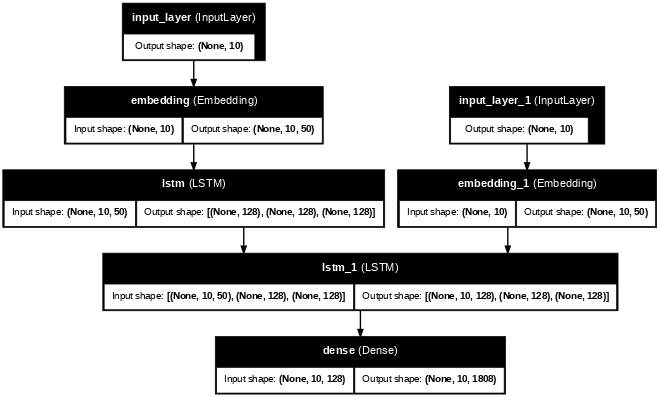


MODELO SOLO ENCODER:



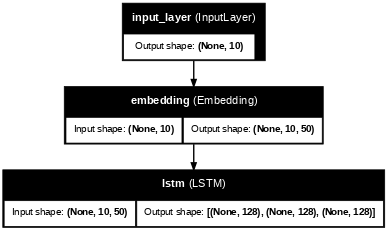


MODELO SOLO DECODER:



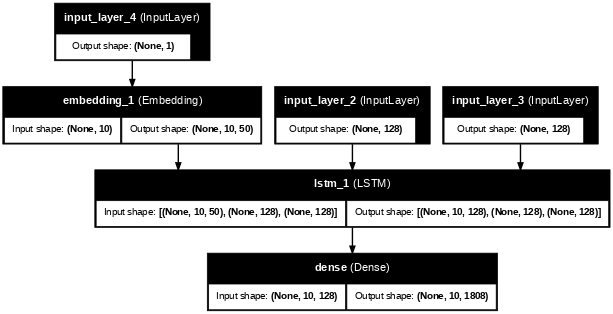


---------------------------------------------------------------------
ESCENARIO 2
---------------------------------------------------------------------


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 10, 50)         │         27,850 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 50)          │         26,550 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 128), (None,   │         91,648 │ embedding_2[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 1, 128),       │         91,648 │ embedding_3[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_2[0][1],          │
│                           │ 128)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 531)         │         68,499 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 306,195 (1.17 MB)

 Trainable params: 251,795 (983.57 KB)

 Non-trainable params: 54,400 (212.50 KB)


MODELO COMPLETO (ENCODER + DECODER):



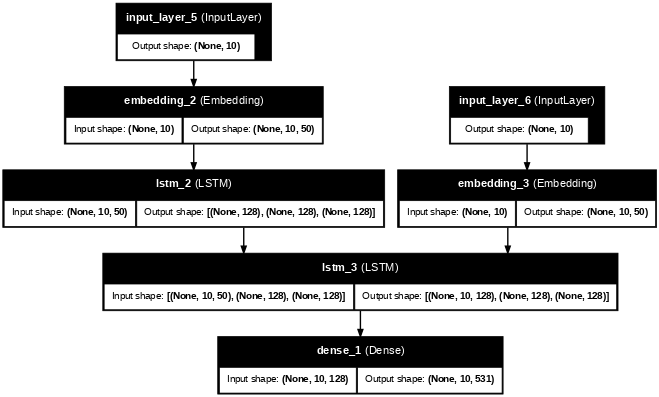


MODELO SOLO ENCODER:



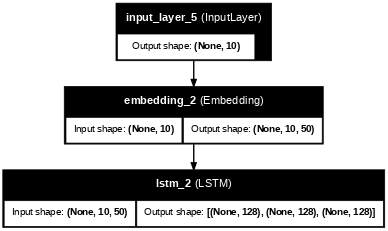


MODELO SOLO DECODER:



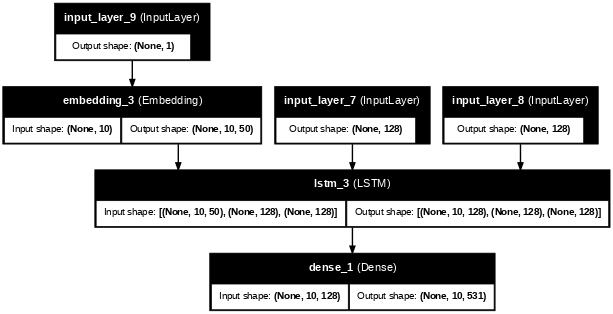


---------------------------------------------------------------------
ESCENARIO 3
---------------------------------------------------------------------


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 10, 50)         │         90,050 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 50)          │         90,400 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 128), (None,   │         91,648 │ embedding_4[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 1, 128),       │         91,648 │ embedding_5[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_4[0][1],          │
│                           │ 128)]                  │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1808)        │        233,232 │ lstm_5[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 596,978 (2.28 MB)

 Trainable params: 416,528 (1.59 MB)

 Non-trainable params: 180,450 (704.88 KB)


MODELO COMPLETO (ENCODER + DECODER):



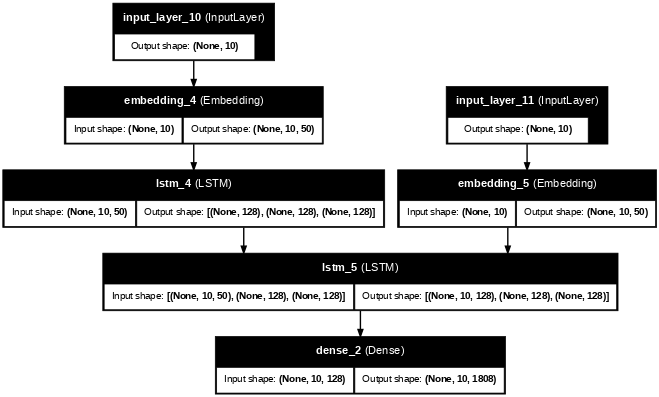


MODELO SOLO ENCODER:



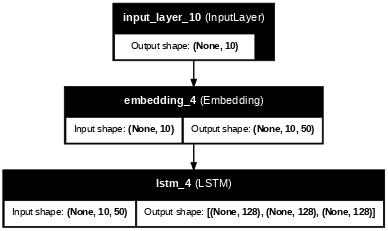


MODELO SOLO DECODER:



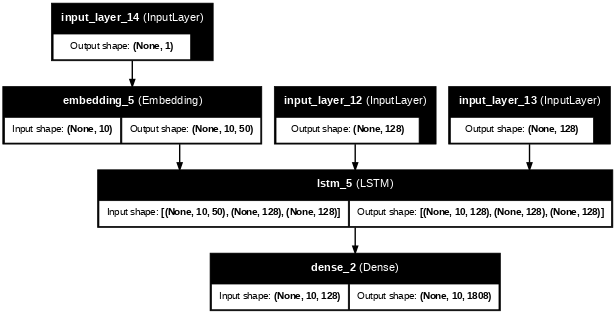


---------------------------------------------------------------------
ESCENARIO 4
---------------------------------------------------------------------


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 10, 50)         │         27,850 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 50)          │         26,550 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 128), (None,   │         91,648 │ embedding_6[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 1, 128),       │         91,648 │ embedding_7[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_6[0][1],          │
│                           │ 128)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 531)         │         68,499 │ lstm_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 306,195 (1.17 MB)

 Trainable params: 251,795 (983.57 KB)

 Non-trainable params: 54,400 (212.50 KB)


MODELO COMPLETO (ENCODER + DECODER):



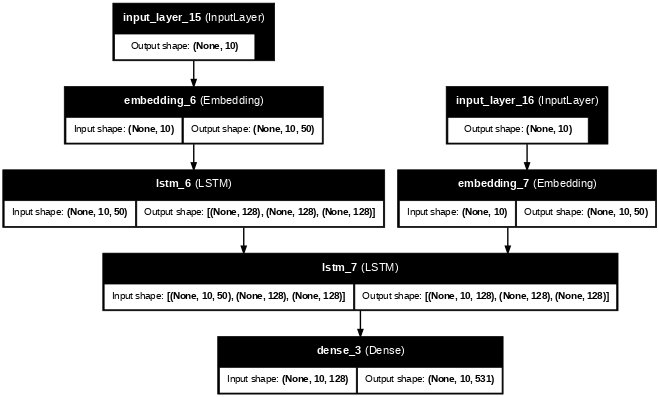


MODELO SOLO ENCODER:



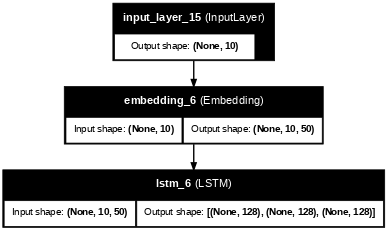


MODELO SOLO DECODER:



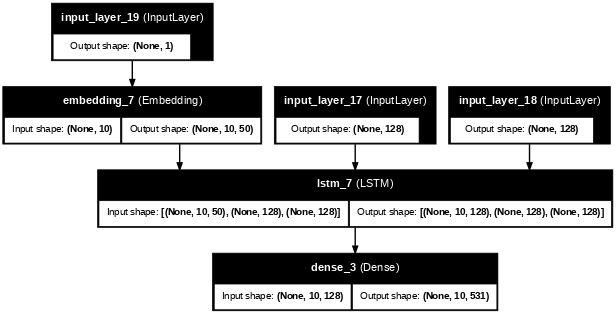


---------------------------------------------------------------------
ESCENARIO 5
---------------------------------------------------------------------


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_21            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 10, 300)        │        540,300 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 1, 300)         │        542,400 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, 128), (None,   │        219,648 │ embedding_8[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, 1, 128),       │        219,648 │ embedding_9[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_8[0][1],          │
│                           │ 128)]                  │                │ lstm_8[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 1808)        │        233,232 │ lstm_9[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,755,228 (6.70 MB)

 Trainable params: 672,528 (2.57 MB)

 Non-trainable params: 1,082,700 (4.13 MB)


MODELO COMPLETO (ENCODER + DECODER):



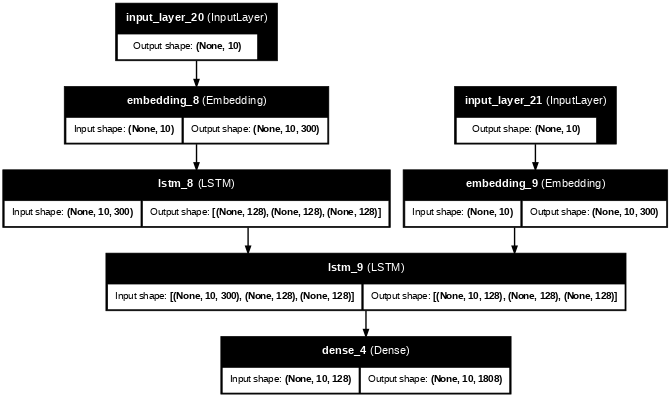


MODELO SOLO ENCODER:



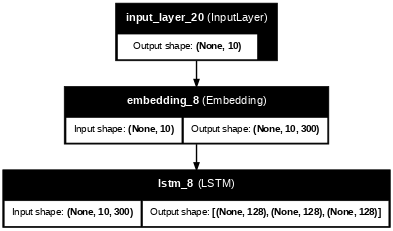


MODELO SOLO DECODER:



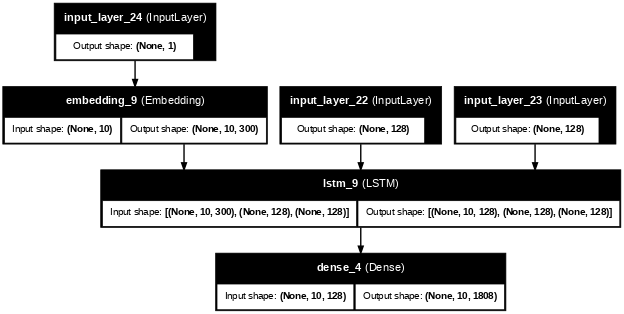


---------------------------------------------------------------------
ESCENARIO 6
---------------------------------------------------------------------


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 10, 300)        │        167,100 │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 1, 300)         │        159,300 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, 128), (None,   │        219,648 │ embedding_10[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, 1, 128),       │        219,648 │ embedding_11[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_10[0][1],         │
│                           │ 128)]                  │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 531)         │         68,499 │ lstm_11[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 834,195 (3.18 MB)

 Trainable params: 507,795 (1.94 MB)

 Non-trainable params: 326,400 (1.25 MB)


MODELO COMPLETO (ENCODER + DECODER):



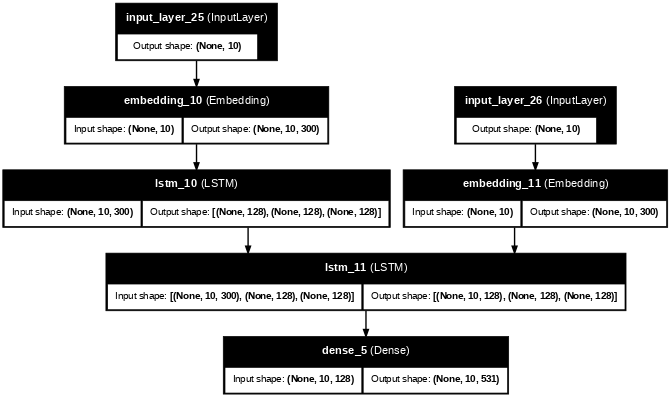


MODELO SOLO ENCODER:



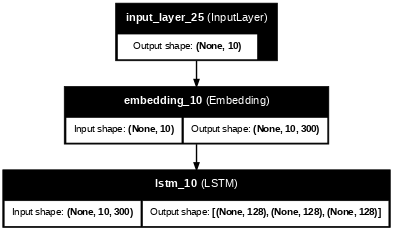


MODELO SOLO DECODER:



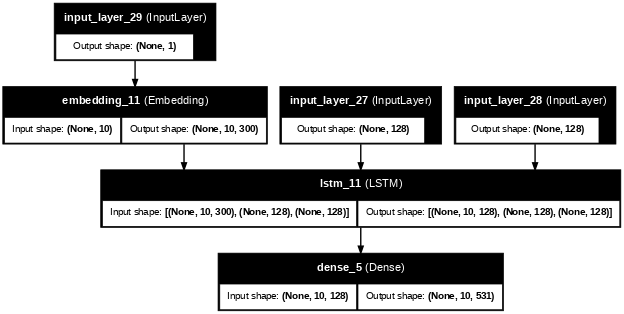


---------------------------------------------------------------------
ESCENARIO 7
---------------------------------------------------------------------


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 10, 300)        │        540,300 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 300)         │        542,400 │ input_layer_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ [(None, 128), (None,   │        219,648 │ embedding_12[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ [(None, 1, 128),       │        219,648 │ embedding_13[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_12[0][1],         │
│                           │ 128)]                  │                │ lstm_12[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 1808)        │        233,232 │ lstm_13[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,755,228 (6.70 MB)

 Trainable params: 672,528 (2.57 MB)

 Non-trainable params: 1,082,700 (4.13 MB)


MODELO COMPLETO (ENCODER + DECODER):



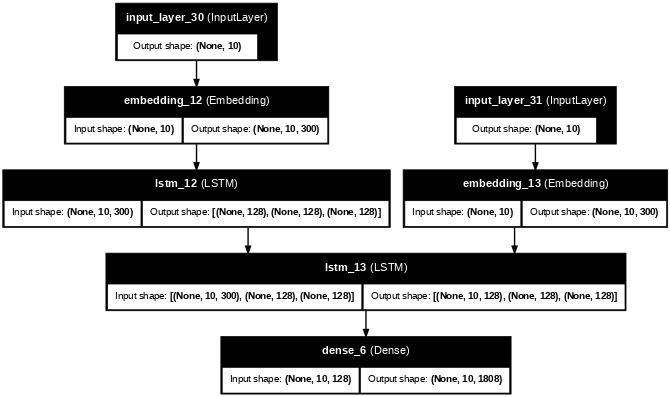


MODELO SOLO ENCODER:



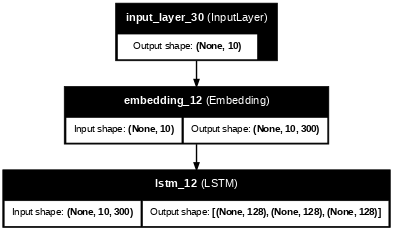


MODELO SOLO DECODER:



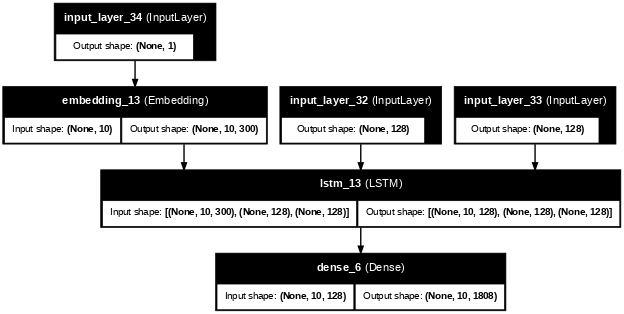


---------------------------------------------------------------------
ESCENARIO 8
---------------------------------------------------------------------


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 10, 300)        │        540,300 │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_36            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 256), (None,   │        439,296 │ embedding_14[0][0]     │
│ (Bidirectional)           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 1, 300)         │        542,400 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][2]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256)            │              0 │ bidirectional[0][3],   │
│ (Concatenate)             │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ [(None, 1, 256),       │        570,368 │ embedding_15[0][0],    │
│                           │ (None, 256), (None,    │                │ concatenate[0][0],     │
│                           │ 256)]                  │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 1808)        │        464,656 │ lstm_15[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,557,020 (9.75 MB)

 Trainable params: 1,474,320 (5.62 MB)

 Non-trainable params: 1,082,700 (4.13 MB)


MODELO COMPLETO (ENCODER + DECODER):



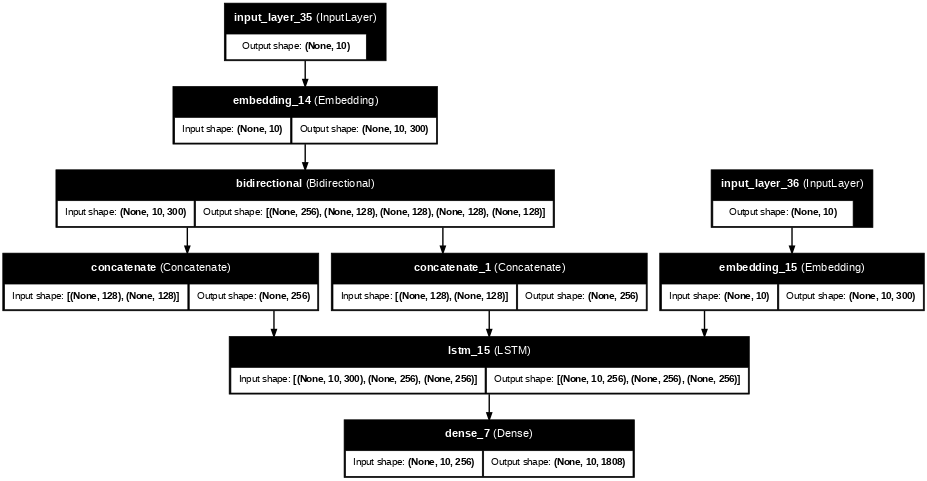


MODELO SOLO ENCODER:



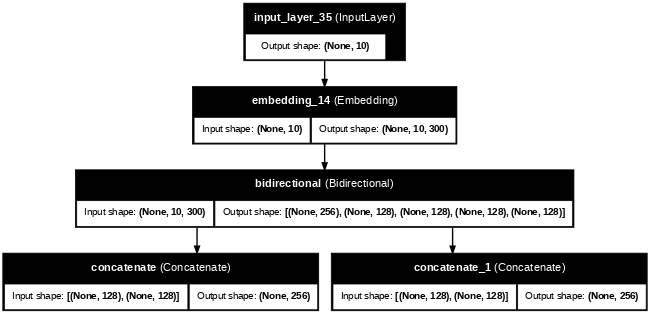


MODELO SOLO DECODER:



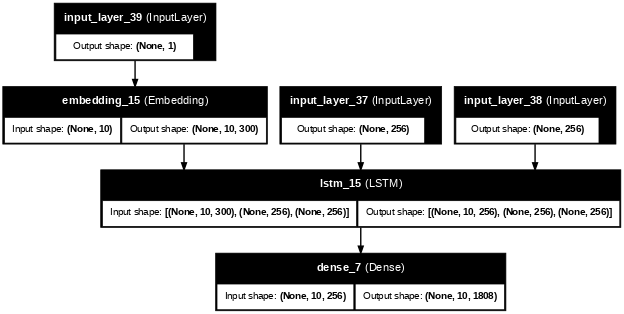


---------------------------------------------------------------------
ESCENARIO 9
---------------------------------------------------------------------


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_41            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 10, 300)        │        540,300 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 1, 300)         │        542,400 │ input_layer_41[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ [(None, 128), (None,   │        219,648 │ embedding_16[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ [(None, 1, 128),       │        219,648 │ embedding_17[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_16[0][1],         │
│                           │ 128)]                  │                │ lstm_16[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1, 1808)        │        233,232 │ lstm_17[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,755,228 (6.70 MB)

 Trainable params: 672,528 (2.57 MB)

 Non-trainable params: 1,082,700 (4.13 MB)


MODELO COMPLETO (ENCODER + DECODER):



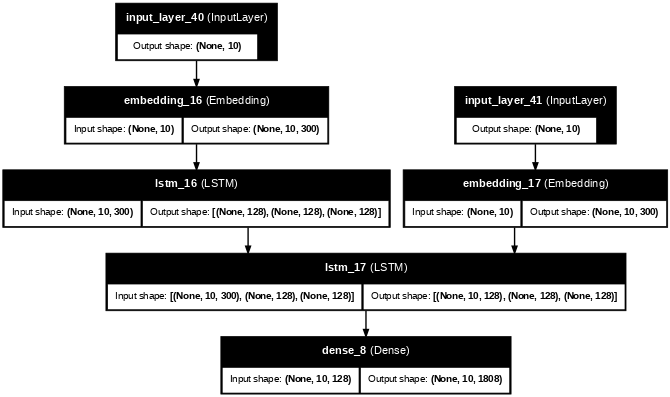


MODELO SOLO ENCODER:



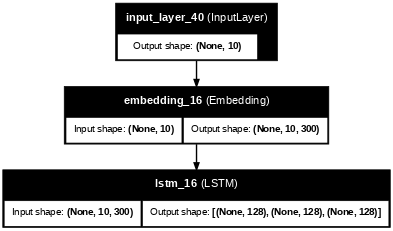


MODELO SOLO DECODER:



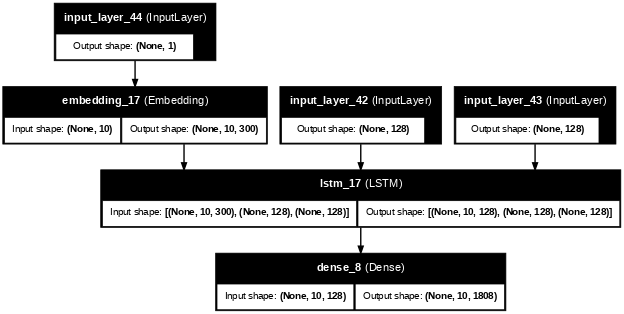


---------------------------------------------------------------------
ESCENARIO 0
---------------------------------------------------------------------


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 10, 300)        │        540,300 │ input_layer_45[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_46            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 256), (None,   │        439,296 │ embedding_18[0][0]     │
│ (Bidirectional)           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_19 (Embedding)  │ (None, 1, 300)         │        542,400 │ input_layer_46[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256)            │              0 │ bidirectional_1[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][2]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 256)            │              0 │ bidirectional_1[0][3], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ [(None, 1, 256),       │        570,368 │ embedding_19[0][0],    │
│                           │ (None, 256), (None,    │                │ concatenate_2[0][0],   │
│                           │ 256)]                  │                │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1808)        │        464,656 │ lstm_19[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,557,020 (9.75 MB)

 Trainable params: 1,474,320 (5.62 MB)

 Non-trainable params: 1,082,700 (4.13 MB)


MODELO COMPLETO (ENCODER + DECODER):



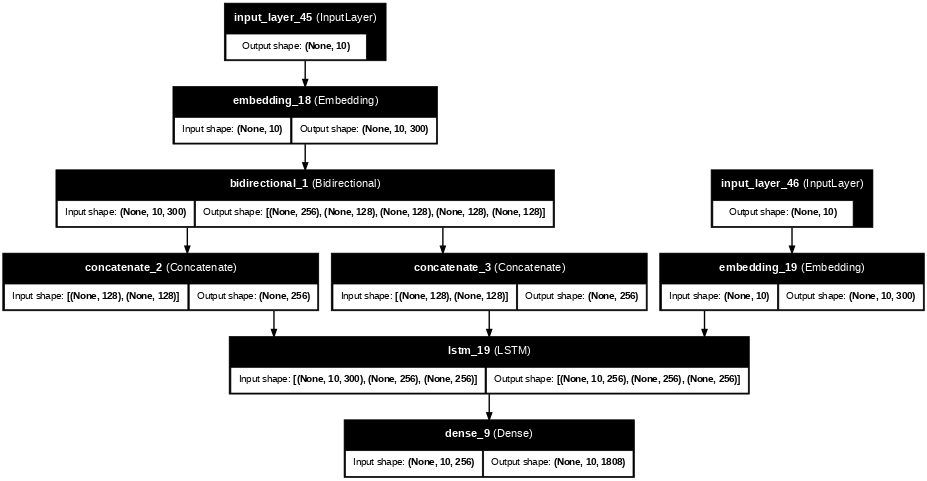


MODELO SOLO ENCODER:



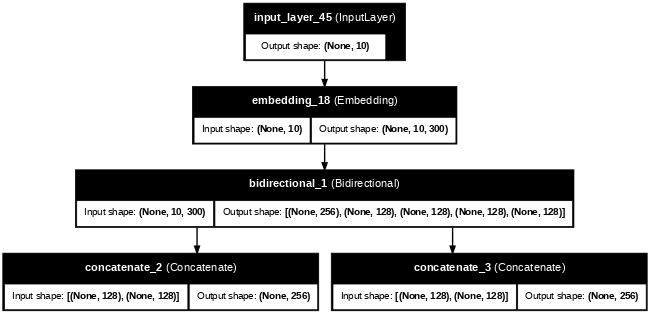


MODELO SOLO DECODER:



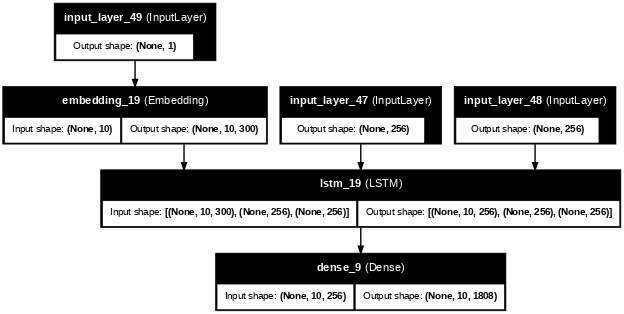

In [47]:
# Recorrer modelos instanciados
for scenario, model in models.items():

  print('\n---------------------------------------------------------------------')
  print(f'ESCENARIO {scenario[-1]}')
  print('---------------------------------------------------------------------')

  # Resumen de la arquitectura del modelo.
  models[scenario]['full_model'].summary()

  plotModels(scenario, models[scenario])

### Entrenamiento

In [48]:
# Parámetros de entrenamiento
n_epochs = 100
p_validation_split = 0.2

In [49]:
# Detener el entrenamiento para evitar sobreajuste
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear pérdida sobre el conjunto de validación
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
    verbose=1,  # Mostrar información durante el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del mejor modelo
)

In [50]:
# Recorrer modelos a entrenar
for scenario, model in models.items():
  print('\n---------------------------------------------------------------------')
  print(f'ENTRENAMIENTO ESCENARIO {scenario[1:]}')
  print('---------------------------------------------------------------------')


  # Crear nueva instancia de callback por modelo (para que no recuerde instancia global del modelo anterior)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

  models[scenario]['history'] = model['full_model'].fit(
                                                      [models[scenario]['sequences'][0], models[scenario]['sequences'][1]], # Entradas
                                                      np.expand_dims(models[scenario]['sequences'][2], -1), # Salidas esperadas
                                                      epochs=n_epochs, # Número de épocas
                                                      validation_split=p_validation_split, # Porcentaje de datos para validación
                                                      callbacks=[early_stopping])


---------------------------------------------------------------------
ENTRENAMIENTO ESCENARIO 1
---------------------------------------------------------------------
Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4694 - loss: 4.2442 - val_accuracy: 0.6098 - val_loss: 2.2817
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6176 - loss: 2.1043 - val_accuracy: 0.6480 - val_loss: 2.1053
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6695 - loss: 1.8782 - val_accuracy: 0.6722 - val_loss: 1.9826
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6890 - loss: 1.7374 - val_accuracy: 0.6826 - val_loss: 1.9098
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7019 - loss: 1.6292 - val_accuracy: 0.6894 - val_loss: 1.8580
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7121 - loss: 1.5550 - val_accuracy: 0.6983 - val_loss: 1.8149
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - ac

#### Resultados comparativos de entrenamiento

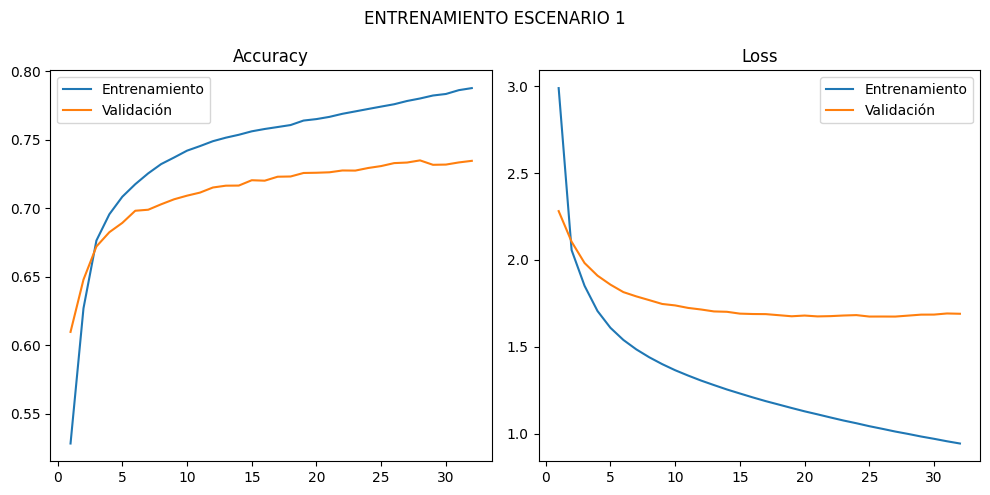

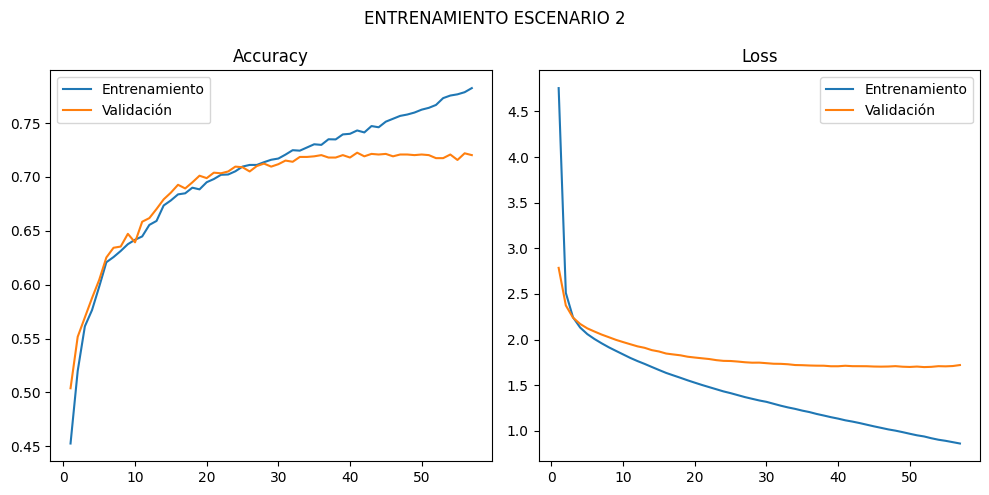

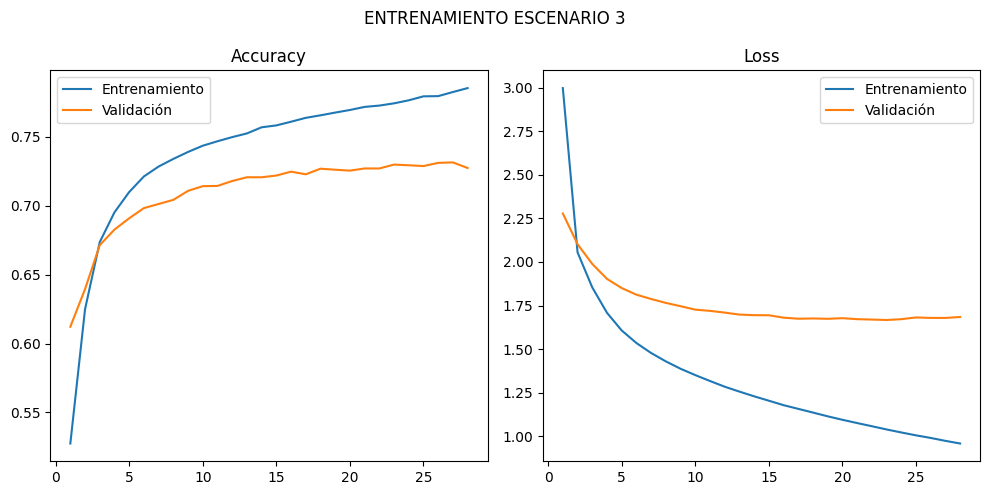

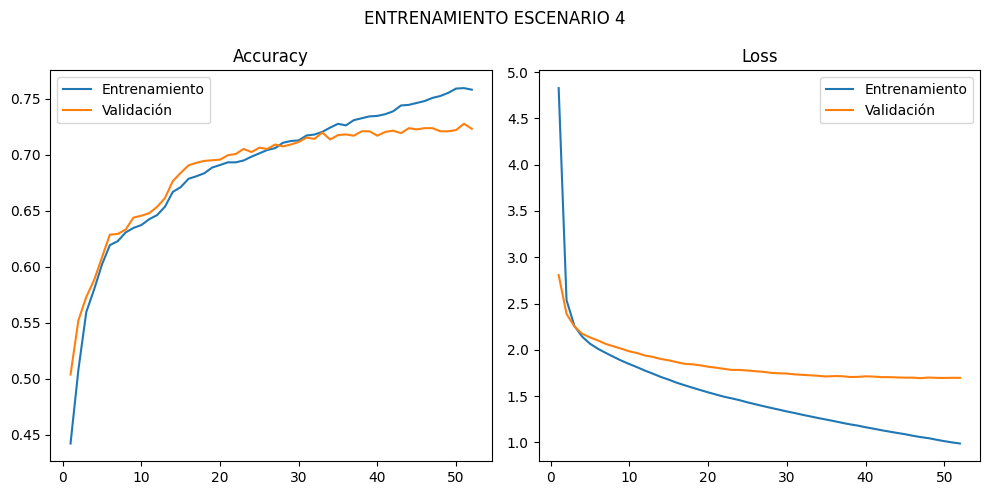

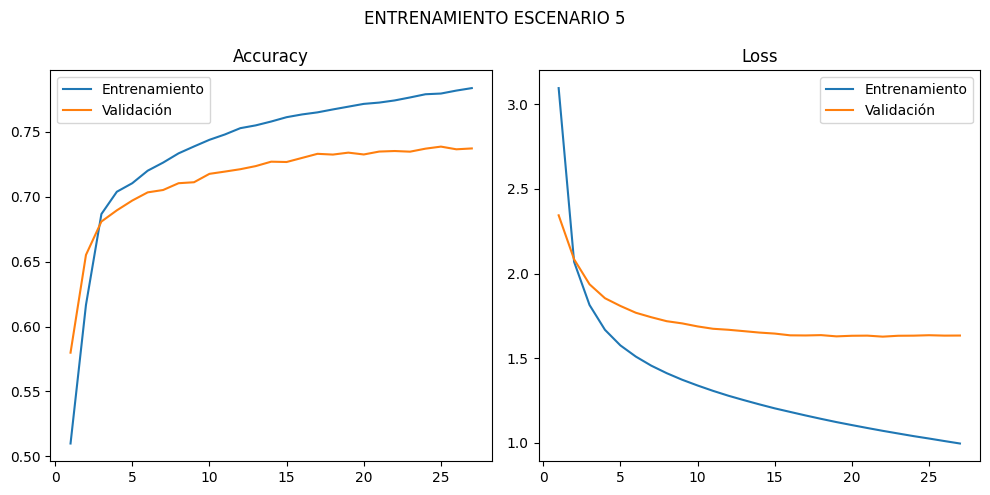

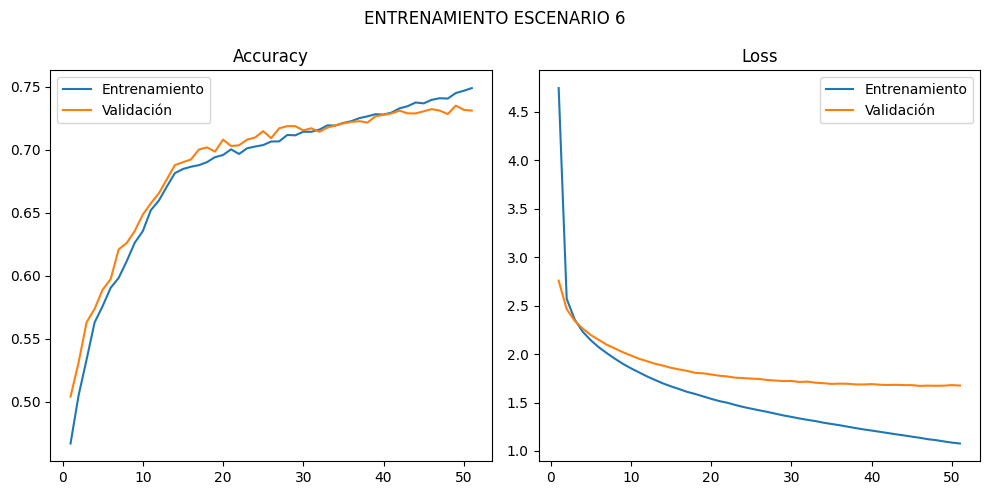

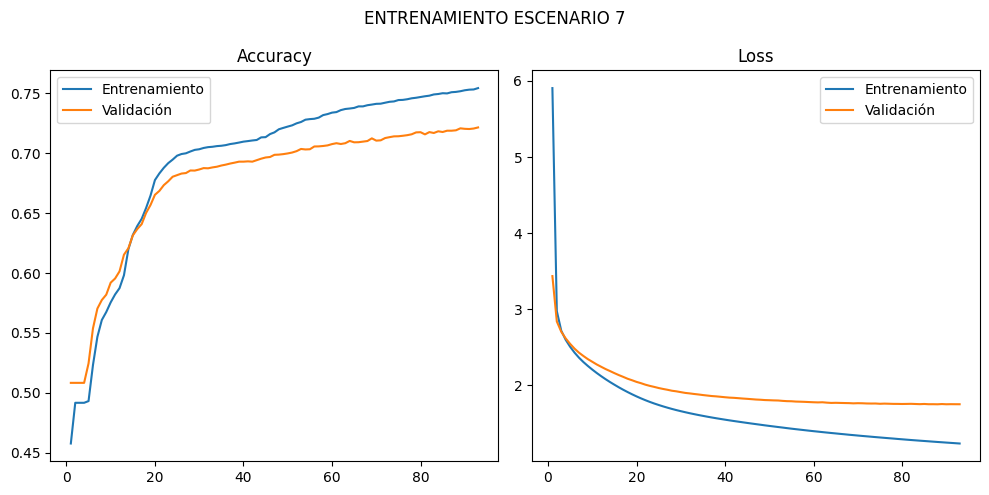

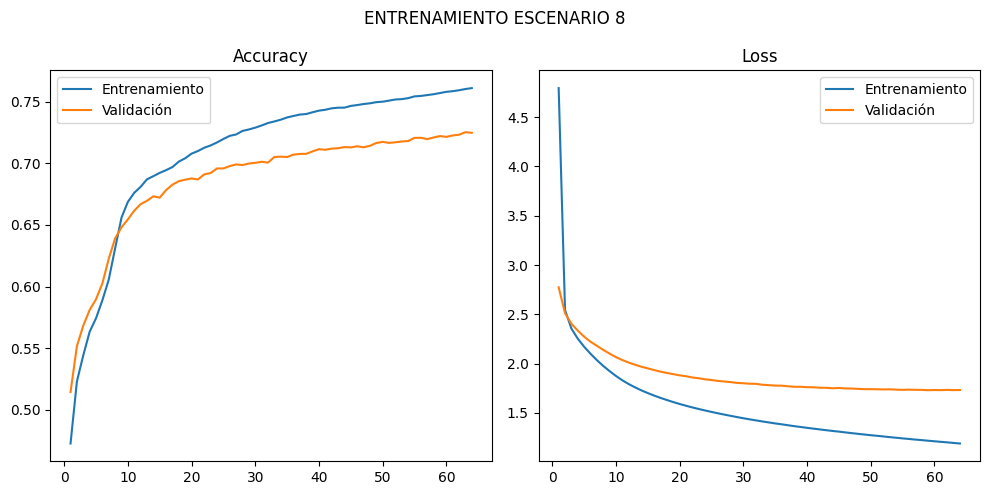

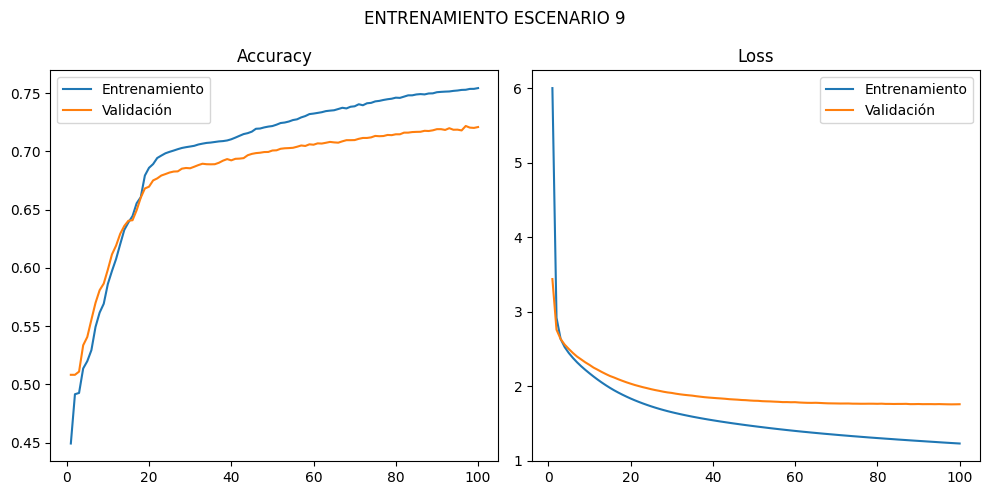

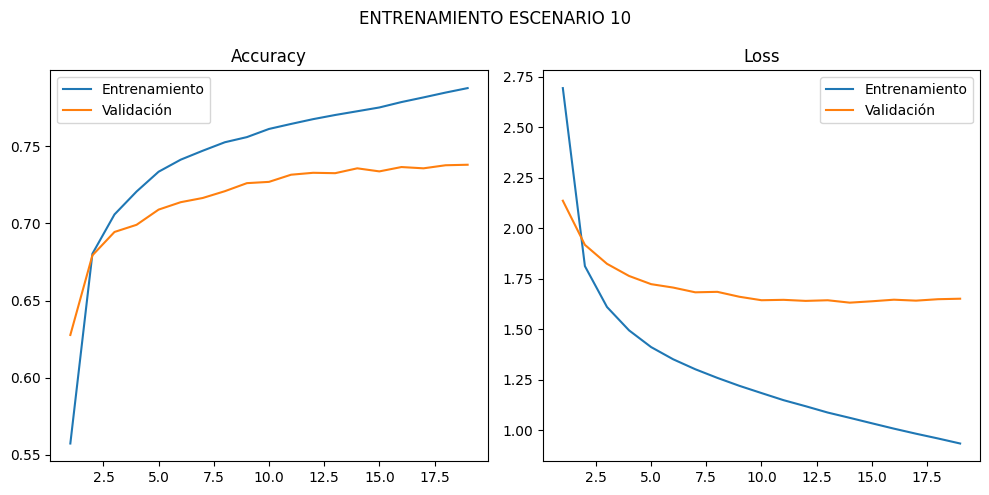

In [51]:
# Recorrer modelos para graficar resultados de entrenamiento
for scenario, model in models.items():

  hist = models[scenario]['history'].history

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  epoch_count = range(1, n_epochs + 1)

  hist['accuracy'].extend([None] * (n_epochs - len(hist['accuracy'])))
  sns.lineplot(x=epoch_count,  y=hist['accuracy'], label='Entrenamiento', ax=axes[0])
  hist['val_accuracy'].extend([None] * (n_epochs - len(hist['val_accuracy'])))
  sns.lineplot(x=epoch_count,  y=hist['val_accuracy'], label='Validación', ax=axes[0])
  axes[0].set_title("Accuracy")

  hist['loss'].extend([None] * (n_epochs - len(hist['loss'])))
  sns.lineplot(x=epoch_count,  y=hist['loss'], label='Entrenamiento', ax=axes[1])
  hist['val_loss'].extend([None] * (n_epochs - len(hist['val_loss'])))
  sns.lineplot(x=epoch_count,  y=hist['val_loss'], label='Validación', ax=axes[1])
  axes[1].set_title("Loss")

  plt.suptitle(f'ENTRENAMIENTO ESCENARIO {scenario[1:]}')
  plt.tight_layout()
  plt.show()



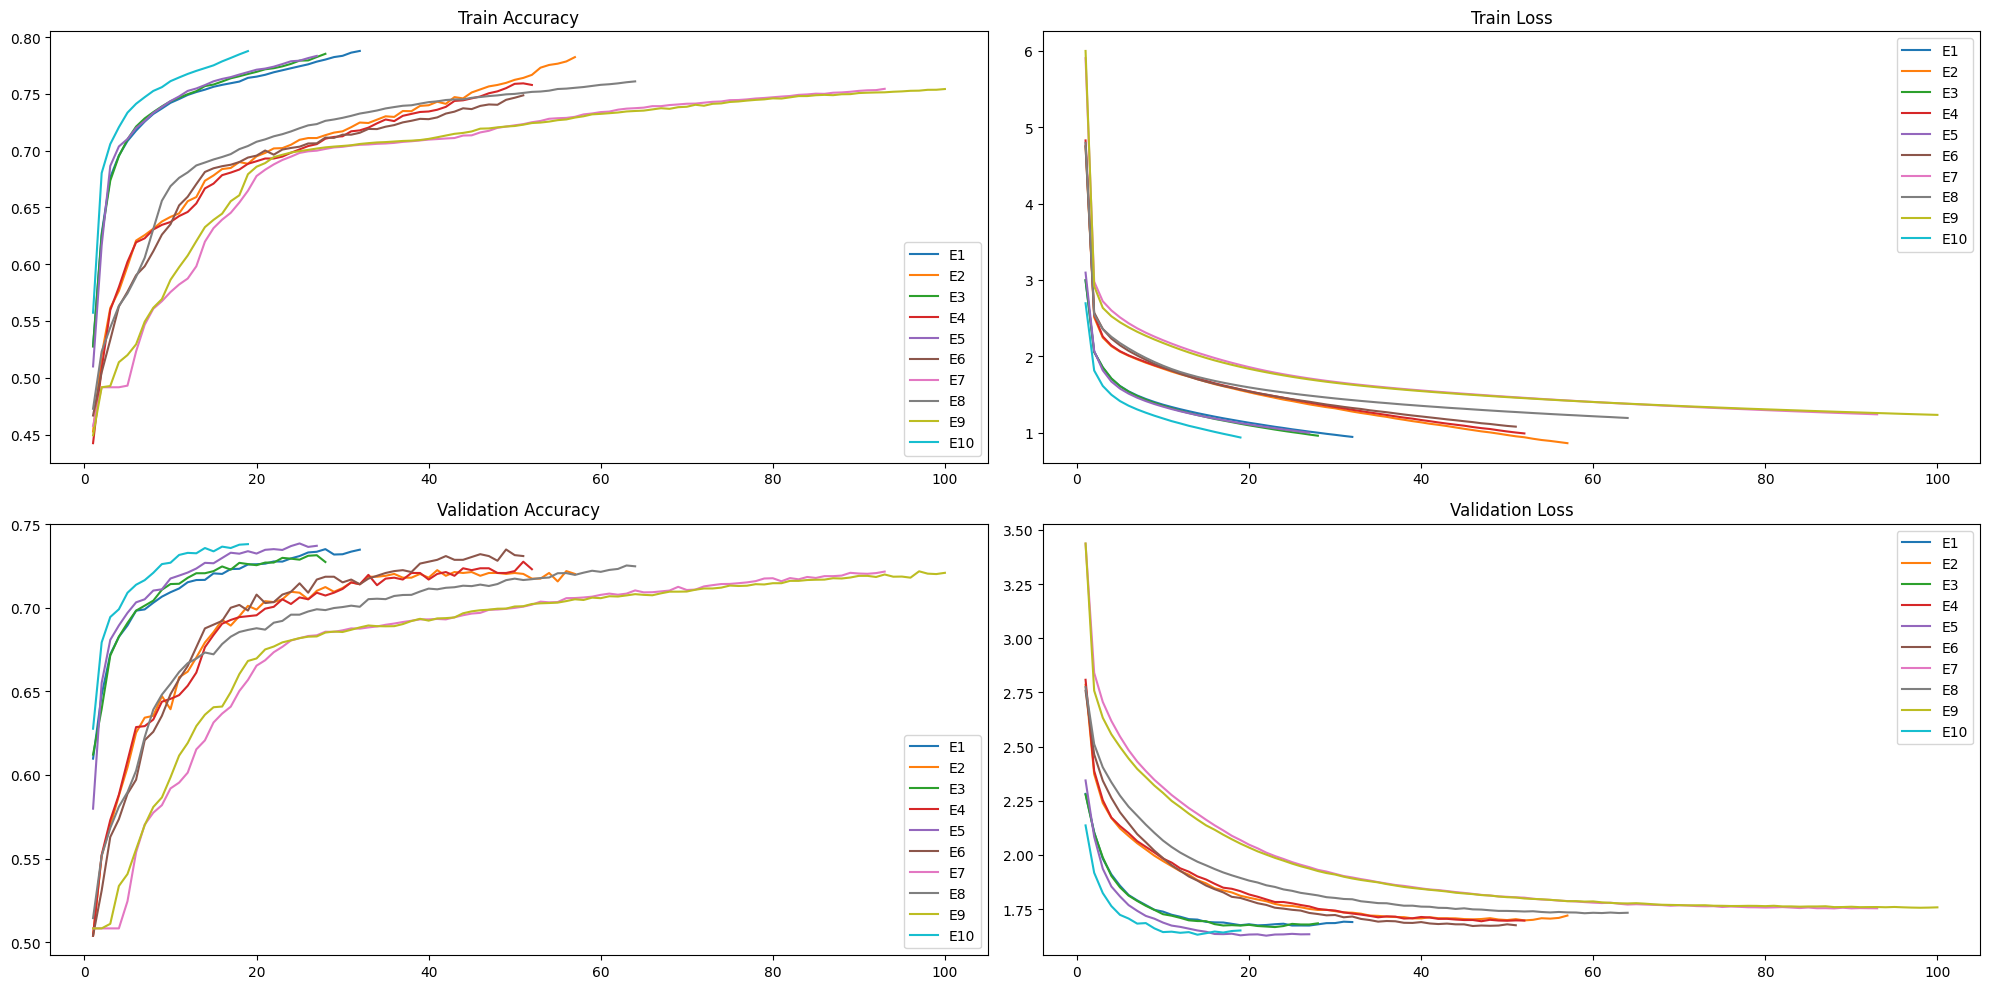

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for scenario, model in models.items():

  hist = models[scenario]['history'].history

  sns.lineplot(x=epoch_count,  y=hist['accuracy'], label=scenario, ax=axes[0, 0])
  axes[0, 0].set_title("Train Accuracy")

  sns.lineplot(x=epoch_count,  y=hist['loss'], label=scenario, ax=axes[0, 1])
  axes[0, 1].set_title("Train Loss")

  sns.lineplot(x=epoch_count,  y=hist['val_accuracy'], label=scenario, ax=axes[1, 0])
  axes[1, 0].set_title("Validation Accuracy")

  sns.lineplot(x=epoch_count,  y=hist['val_loss'], label=scenario, ax=axes[1, 1])
  axes[1, 1].set_title("Validation Loss")

plt.tight_layout()
plt.show()


#### Guardar los modelos entrenados

In [53]:
for scenario, model in models.items():

  # Guardar el modelo
  model['full_model'].save(f'modelo_lstm_{scenario}.keras')

  # Guardar el tokenizador que se usó para el modelo
  with open(f'tokenizer_IN_{scenario}.json', 'w') as f:
    f.write(model['input_tokenizer'].to_json())

  with open(f'tokenizer_OUT_{scenario}.json', 'w') as f:
    f.write(model['output_tokenizer'].to_json())

  print(f'Model {scenario}... saved.')

Model E1... saved.
Model E2... saved.
Model E3... saved.
Model E4... saved.
Model E5... saved.
Model E6... saved.
Model E7... saved.
Model E8... saved.
Model E9... saved.
Model E10... saved.


### Resultados

In [54]:
def QABot(input_seq, encoder_model, decoder_model, word2idx_outputs, idx2word_target, max_out_len = 10, verbose=1):

    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq, verbose=verbose)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=verbose)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

Selección aleatoria de la entrada:

In [55]:
for scenario, model in models.items():

  # Seleccionar aleatoriamente una oración de la lista input_sentences
  input_sentences = model['input_sentences']
  i = np.random.choice(len(input_sentences))

  encoder_input_sequences = models['E1']['sequences'][0]

  input_seq = encoder_input_sequences[i:i+1]

  # Pasa la secuencia al modelo que toma la entrada y genera una respuesta
  response = QABot(input_seq,
                   model['encoder_model'],
                   model['decoder_model'],
                   model['idx']['word2idx_outputs'],
                   model['idx']['idx2word_target'],
                   max_len,
                   verbose=0)


  print('-')
  print('Input:', input_sentences[i])
  print(f'Response {scenario}:', response)


-
Input: haha
Response E1: i love to read
-
Input: ok
Response E2: hello how are you


-
Input: yes
Response E3: what do you do for a living
-
Input: what game do you play 
Response E4: what do you do for a living
-
Input: i m employed at supermarket
Response E5: what do you do for a living
-
Input: nice what are your hobbies 
Response E6: i love to go


-
Input: ohh wwwowww
Response E7: what do you do for a living
-
Input: i am sure you will one day 
Response E8: i am a vegan
-
Input: do you love pets 
Response E9: i am a vegan
-
Input: do you have any hobbies 
Response E10: i like to play video games


In [56]:
inputs = ["How are you?",
          "Do you read?",
          "Do you have any pet?",
          "Where are you from?",
          "Are you a human?",
          "The cat is under the table",
          "How old are you?",
          "Have you ever been to France?",
          "Can you play the piano?",
          "I like swimming",
          "I think this conversation is pretty silly"
          ]

for scenario, model in models.items():

  print('---------------------------------------')
  print(f'Conversation with ChatBot {scenario}:')
  print('---------------------------------------')

  for input_test in inputs:

    input_tokenizer = model['input_tokenizer']

    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    #print("Representación en vector de tokens de ids", integer_seq_test)

    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_len)
    #print("Padding del vector:", encoder_sequence_test)

    response = QABot(encoder_sequence_test,
                   model['encoder_model'],
                   model['decoder_model'],
                   model['idx']['word2idx_outputs'],
                   model['idx']['idx2word_target'],
                   max_len,
                   verbose=0)

    print('Input:', input_test)
    print('Response:', response)
    print()

---------------------------------------
Conversation with ChatBot E1:
---------------------------------------
Input: How are you?
Response: i am fine

Input: Do you read?
Response: i m fine

Input: Do you have any pet?
Response: i like to play video games

Input: Where are you from?
Response: i am not sure what you mean

Input: Are you a human?
Response: i am a student

Input: The cat is under the table
Response: i am a vegan

Input: How old are you?
Response: i am fine

Input: Have you ever been to France?
Response: i am a vegan

Input: Can you play the piano?
Response: i like to go to the beach

Input: I like swimming
Response: what do you do for a living

Input: I think this conversation is pretty silly
Response: what do you do for a living

---------------------------------------
Conversation with ChatBot E2:
---------------------------------------
Input: How are you?
Response: i am fine how are you

Input: Do you read?
Response: i like to read

Input: Do you have any pet?
Response

## Conclusiones

La coherencia de las preguntas y respuestas en el conjunto de datos de entrenamiento tiene un gran impacto en el desempeño de un modelo seq2seq basado en LSTM para un chatbot.

En un modelo seq2seq, el objetivo es aprender la relación entre secuencias de entrada (preguntas) y secuencias de salida (respuestas). Si las preguntas y respuestas en el conjunto de datos de entrenamiento no son coherentes entre sí, el modelo aprenderá patrones incorrectos y no podrá generar respuestas adecuadas en situaciones reales.   
<br>
Ejemplo de preguntas y respuestas del conjunto de datos propuesto para entrenar (tomadas de los diálogos mejor valorados):

* how are you: i am a student

* i like to play video games: how many friends
<br>

Es por esto que, en el resultado final se observan algunos efectos negativos como:

* Respuestas inapropiadas o sin sentido: Algunas preguntas y respuestas del set de datos no están relacionadas, por lo que, el modelo aprende a generar respuestas que no corresponden a las preguntas reales, lo que resulta en interacciones sin sentido o irrelevantes.

* Pérdida de contexto: Los modelos LSTM intentan aprender dependencias temporales y de contexto a través de las secuencias. Si las respuestas no siguen de manera coherente las preguntas, el modelo no puede ser capaz de aprender relaciones temporales adecuadas, perdiendo la capacidad de mantener una conversación fluida.

* Falta de diversidad y riqueza en las respuestas: Si las respuestas no son variadas o interesantes, el modelo termina generando respuestas monótonas o repetitivas, lo cual afecta la calidad general de la interacción.

Resultados de las pruebas comparativas:

| Escenario | Embeddings | Vocabulario | Sentencias | Learning Rate | LSTM Direccional | Dropout | VAL ACCURACY | VAL LOSS |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| E1 | Glove | 2500 | Full | Default | No | No | 0.7267 | 1.6654
| E2 | Glove | 2500 | Best Score | Default | No | No | 0.7225 | 1.7222
| E3 | Glove | 8000 | Full | Default | No | No | 0.7303 | 1.6681
| E4 | Glove | 8000 | Best Score | Default | No | No | 0.7169 | 1.6993
| E5 | Fasttext | 8000 | Full | Default | No | No | 0.7321 | 1.6342
| E6 | Fasttext | 8000 | Best Score | Default | No | No | 0.7253 | 1.6836
| E7 | Fasttext | 8000 | Full | 0.0001 | No | No | 0.7163 | 1.7602
| E8 | Fasttext | 8000 | Full | 0.0001 | Si | 0.2 | 0.7253 | 1.7250
| E9 | Fasttext | 8000 | Full | 0.0001 | No | 0.2 | 0.7229 | 1.7558
| E10 | Fasttext | 8000 | Full | Default | Si | 0.3 | 0.7332 | 1.6354

Los modelos en los que se seleccionó un subset de diálogos evidencian menos variabilidad en las respuestas, lo que es esperable, ya que, en ese caso, el modelo aprende sobre un conjunto más reducido de ejemplos, lo que podría hacer que las respuestas sean menos diversas y menos precisas para inputs fuera de ese conjunto.  



Los modelos entrenados con embeddings de Glove muestran algunas respuestas interesantes, como por ejemplo:

<i>Input: How are you?  
Response: i m fine  
  
Input: Do you read?  
Response: i like to read  
  
Input: I like swimming  
Response: i like to go to the beach  </i>  
<br>
Sin embargo, otras respuestas terminan siendo repetitivas y poco acertadas, por ejemplo:

<i>Input: Have you ever been to France?  
Response: i am a vegan  
  
Input: Can you play the piano?  
Response: i am a vegan  
  
Input: Do you have any pet?  
Response: i am fine  
  
Input: Where are you from?  
Response: i am fine  </i>



Al utilizar, capas de embeddings preentrenados, el modelo se puede beneficiar si las representaciones son más grandes (como las de 300 dimensiones de Fasttext) ya que son más capaces de capturar relaciones semánticas complejas.   

Sin embargo, no se observan mejoras significativas en los resultados al aumentar la dimensión de los embeddings.  
Por el contrario, los modelos entrenados con Fasttext muestran también algunas respuestas repetitivas y poco coherentes.

Los embeddings de 300 dimensiones pueden resultar en representaciones menos útiles en este caso particular, ya que embeddings más grandes, aunque poderosos, necesitan muchos datos para generalizar correctamente.  
En este caso en que el conjunto de datos es pequeño y de baja calidad, es probable que no logren aprender de manera efectiva.

Si bien las LSTM bidireccionales son poderosas para capturar contextos tanto pasados como futuros, la combinación de bidireccionalidad con otros problemas (como datos insuficientes, mala optimización o mal ajuste de parámetros) puede causar que las predicciones sean incorrectas o incoherentes.

En las pruebas en donde se redujo la tasa de aprendizaje, tampoco se observan mejoras en las prediciones.
Al reducir demasiado la tasa de aprendizaje, el optimizador puede volverse demasiado lento para hacer ajustes significativos en los parámetros del modelo durante el entrenamiento. Esto puede llevar a que el modelo no aprenda lo suficientemente rápido y se quede atrapado en un óptimo local o no converja adecuadamente.

Resultados con el modelo del escenario 10, con regularización por dropout de 0.3 y LSTM bidireccional:

In [57]:
# Modelo: https://drive.google.com/uc?id=1IrMZnWecISjpTb7wxWUwZ6u-yyX1om95
# Tokenizador IN: https://drive.google.com/uc?id=1KUf9C1NspsvTdIa_C0HBgrSKOwHV7VQa
# Tokenizador OUT: https://drive.google.com/uc?id=1_BqjzZgQmNoVujB2SrXyFs8iQ-oVDGz1

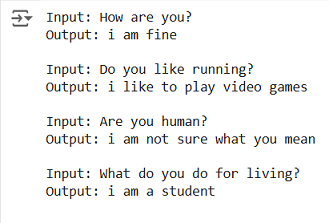

In [83]:
inputs = ["How are you?",
          "Do you like running?",
          "Are you human?",
          "What do you do for living?"
          ]

scenario = 'E10'
model_final = models[scenario]

for input_test in inputs:

  input_tokenizer = model['input_tokenizer']

  integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
  encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_len)

  response = QABot(encoder_sequence_test,
                  model['encoder_model'],
                  model['decoder_model'],
                  model['idx']['word2idx_outputs'],
                  model['idx']['idx2word_target'],
                  max_len,
                  verbose=0)

  print('Input:', input_test)
  print('Output:', response)
  print()

Input: How are you?
Output: i am fine

Input: Do you like running?
Output: i like to play video games

Input: Are you human?
Output: i am not sure what you mean

Input: What do you do for living?
Output: i am a student

